## Import Libraries and Packages

In [1]:
import pandas as pd    
import numpy as np
import glob
import string
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from math import log10, floor
from sklearn.utils import resample  #import function for bootstrapping 
import matplotlib.pyplot as plt     #import plotting library
import scipy as sp
from sklearn.metrics import log_loss #import function to calculate log loss
import re # package to search strings by reg expressions
from tqdm.auto import tqdm
import pickle
from scipy.stats import levene, ttest_ind



## Set Required Variables

In [2]:
lda = LinearDiscriminantAnalysis()  #store LDA functions as lda
upper_bound = 181  #set upper bound near to molecular weight, exclusive 
lower_bound = 41   #set lower bound, inclusive, not all MS go down to 14
plt.style.use('ggplot') #set ggplot as plotting style
plt.rcParams['axes.facecolor'] = 'white' #set plot background as white

#Select which actions to perform
convert = False
avg_spectra_plots = False
welch_tests = False
avg_instrument_plots = False
optimize = False
bs = 50 #switched to 150 below for MMC
plot_no_threshold = False
calc_limitations = False #initial method of limitations - by ordered list of fragment abundances
calc_limitations_2 = True #by incrementally increasing abundance threshold
minimum_spectra = False
plot_limitations = False
lda_scalings_plots = True
NIST_test = False
coelution_test = False



## Define Functions

In [3]:
def read_file(filepath, lower_bound=41, upper_bound=181, norm = 9999, manual = False, library = False): 
    """Read in data file from m/z 41-180, set normalization"""
    if library: #library samples have different delimiter, header, and column names
        df = pd.read_csv(filepath, header=1, sep="\t", skipinitialspace = True) #read in files, one header, tab delimited, skip any initial spaces
        df["m/z"] = np.round(df["m/z"]).astype(np.int64) #round the values in the m/z column and treat as integers
        df = df[df["m/z"] >= lower_bound] #remove any m/z under the lower bound
        df = df[df["m/z"] < upper_bound] #remove any m/z equal or above the higher bound
        df["Abundance"] = df["Abundance"]/np.max(df["Abundance"])*norm #base peak normalization to the specified value
        df = df.groupby("m/z").max()  #if an integer m/z has more than one abundance, use the max abundance
        df = df.reindex(np.arange(lower_bound, upper_bound)).fillna(0) #fill in any empty m/z with 0
        return df
    else:
        if manual:  #manually tabulated spectra have different delimiters
            df = pd.read_csv(filepath, sep="\t", skiprows=[0, 1, 2, 3], names = ['m/z', 'abund.'], skipinitialspace = True)
        else:
            df = pd.read_csv(filepath, sep=" ", skiprows=[0, 1, 2, 3], names=['m/z', 'abund.'], skipinitialspace = True)
        df["m/z"] = np.round(df["m/z"]).astype(np.int64)  #create column for m/z values, round to integers
        df = df[df["m/z"] >= lower_bound]                 #limit df to only m/z between m/z range of interest
        df = df[df["m/z"] < upper_bound]
        df["abund."] = df["abund."]/np.max(df["abund."])*norm  #normalize to base peak abundance of 9999
        df = df.groupby("m/z").max()                #if an integer m/z has more than one abundance, use the max abundance
        df = df.reindex(np.arange(lower_bound, upper_bound)).fillna(0)   #fill in any empty m/z with 0
        return df
    
def round_sig(x, sig=2):
    """rounds to two significant figures"""
    return round(x, sig - int(floor(log10(abs(x)))) - 1)

def ms_removal(data_train, data_val, low_percentage=10, high_percentage=10, filter="null", threshold=1, data_test=None):
    """removes portion of MS spectrum"""
    if filter == "null":  # if filter = null, remove specified percentages of low/high m/z values
        number_low = round(low_percentage / 100 * len(
            data_train.columns))  # set the number of low m/z values to keep, rounded to a whole number
        number_high = round(len(data_train.columns) - (high_percentage / 100 * len(
            data_train.columns)))  # set the number of high m/z values to keep, rounded to a whole number
        new_data_train = data_train.iloc[:,
                         number_low:number_high]  # set the new training dataset to only the columns remaining
        new_data_val = data_val.iloc[:,
                       number_low:number_high]  # set the new validation dataset to only the columns remaining
        if data_test is not None:  # if a test set is also incorporated, set to the same columns
            new_data_test = data_test.iloc[:, number_low:number_high]
    else:  # if filter is not null, use filter with threshold
        abundance_threshold = threshold / 100  # divid the threshold by 100 to obtain a percentage
        sample_threshold = (filter / 100) * data_train.shape[
            0]  # the number of samples that must meet the abundance threshold is set by filter as a percentage of the number of training samples
        keep_columns = (
                               data_train > abundance_threshold).sum() >= sample_threshold  # set columns to keep as those whose number of samples that reach the abundance threshold is over the sample threshold
        new_data_train = data_train.loc[:,
                         keep_columns]  # set the new training dataset to only the columns that meet the criteria
        new_data_val = data_val.loc[:,
                       keep_columns]  # set the new validation dataset to only the columns that meet the criteria (in the training set)
        if data_test is not None:  # if there is a test set
            new_data_test = data_test.loc[:,
                            keep_columns]  # set the new test set to only the columns determined by the training set
    if data_test is not None:
        return new_data_train, new_data_val, new_data_test  # return all appropriate new datasets
    else:
        return new_data_train, new_data_val

def scaling(data_train, data_val, type="standard", data_test=None):  # set scaling type
    """select scaling type"""
    scikit_learn_types = ["standard", "mean", "min_max", "quantile", "power",
                          "robust"]  # create a list with scikitlearn based scalers

    if type == "none":
        new_data_train = data_train
        new_data_val = data_val
        if data_test is not None:
            new_data_test = data_test

    if type in scikit_learn_types:

        if type == "standard":
            sc = StandardScaler()  # use standard scaler from scikit learn (mean center, scale to unit variance)
        if type == "mean":
            sc = StandardScaler(
                with_std=False)  # use standard scaler but with scaing to unit variance, mean centering only
        if type == "min_max":
            sc = MinMaxScaler()  # use minmax scaler from scikit learn, scaling features to lie between a given minimum and maximum value, zero and one
        if type == "quantile":
            sc = QuantileTransformer()  # non-parametric transformation to map the data to a uniform distribution with values between 0 and 1, smooths out unusual distributions and is less influenced by outliers than scaling methods
        if type == "power":
            sc = PowerTransformer(
                method='yeo-johnson')  # aim to map data from any distribution to as close to a Gaussian distribution as possible in order to stabilize variance and minimize skewness, performs std scaler after transformation.
        if type == "robust":
            sc = RobustScaler()  # similar to std scaler but with more robust estimated for center and range in the case of outliers
        new_data_train = pd.DataFrame(
            sc.fit_transform(data_train))  # set scaler based on training set, apply to training set
        new_data_val = pd.DataFrame(
            sc.transform(data_val))  # apply scaler as determined by training set, to validation set
        new_data_train.columns = data_train.columns  # change columns names as otherwise the scaler resets to 0,1,2, etc
        new_data_val.columns = data_val.columns  # change columns names as otherwise the scaler resets to 0,1,2, etc
        if data_test is not None:  # if there is a test set
            new_data_test = pd.DataFrame(
                sc.transform(data_test))  # apply scaler as determined by training set, to test set

    if type == "unit":  # scale each m/z to vector length of one
        new_data_train = data_train.divide(np.linalg.norm(data_train, axis=0),
                                           axis=1)  # divide each m/z in a spectrum by the spectrum's vector length
        new_data_val = data_val.divide(np.linalg.norm(data_train, axis=0),
                                       axis=1)  # divide each m/z in a spectrum by the spectrum's vector length
        if data_test is not None:
            new_data_test = data_test.divide(np.linalg.norm(data_train, axis=0), axis=1)


    if type == "pareto":  # perform pareto scaling
        temp_data_train = data_train.subtract(data_train.mean())  # mean center the training dataset
        temp_data_val = data_val.subtract(
            data_train.mean())  # apply the same transformation to the val set as the mean centering of the training set
        keep_columns = data_train.std(
            axis=0) != 0  # only keep columns if the std deviation of the column in the training set is not 0 to avoid errors
        temp_new_data_train = temp_data_train.loc[:,
                              keep_columns]  # create temporary new dataframes with only the new columns
        temp_new_data_val = temp_data_val.loc[:, keep_columns]
        pareto = np.sqrt(temp_new_data_train.std(
            axis=0))  # set the pareto divisor for each m/z as the square root of the standard deviation of each m/z column (training set)
        new_data_train = temp_new_data_train.divide(pareto,
                                                    axis=1)  # divide each value by the pareto value for the m/z column
        new_data_val = temp_new_data_val.divide(pareto,
                                                axis=1)  # divide each value by the pareto value for the m/z column
        new_data_train.columns = temp_new_data_train.columns  # change columns names as otherwise the scaler resets to 0,1,2, etc
        new_data_val.columns = temp_new_data_val.columns
        if data_test is not None:  # perform the above for the test set if applicable
            temp_data_test = data_test.subtract(data_train.mean())
            temp_new_data_test = temp_data_test.loc[:, keep_columns]
            new_data_test = temp_new_data_test.divide(pareto, axis=1)
            new_data_test.columns = temp_new_data_test.columns

    if type == "vast":  # if vast scaling is selected
        sc = StandardScaler()  # set the standard scaler
        keep_columns = data_train.std(
            axis=0) != 0  # only keep columns if the std deviation of the column in the training set is not 0 to avoid errors
        temp_data_train = data_train.loc[:, keep_columns]  # create temporary new dataframes with only the new columns
        temp_data_val = data_val.loc[:, keep_columns]
        cv = temp_data_train.mean(axis=0) / temp_data_train.std(
            axis=0)  # calculate the coefficient of variation for each m/z
        new_data_train = pd.DataFrame(np.multiply(np.array(cv), sc.fit_transform(
            temp_data_train)))  # fit the std scaler based on the training set, transform the training set, the multiply by the CV
        new_data_val = pd.DataFrame(np.multiply(np.array(cv), sc.transform(
            temp_data_val)))  # transform the validation set based on the std scalred, multiply by the CV
        new_data_train.columns = temp_data_train.columns  # change columns names as otherwise the scaler resets to 0,1,2, etc
        new_data_val.columns = temp_data_val.columns
        if data_test is not None:  # perform the above for the test set if applicable
            temp_data_test = data_test.loc[:, keep_columns]
            new_data_test = pd.DataFrame(np.multiply(np.array(cv), sc.transform(temp_data_test)))
            new_data_test.columns = temp_data_test.columns

    if type == "level":  # if level scaling is selected
        keep_columns = data_train.mean(
            axis=0) != 0  # only keep columns if the std deviation of the column in the training set is not 0 to avoid errors
        temp_data_train = data_train.loc[:, keep_columns]  # create temporary new dataframes with only the new columns
        temp_data_val = data_val.loc[:, keep_columns]
        new_data_train = temp_data_train.subtract(temp_data_train.mean(axis=0)).divide(temp_data_train.mean(
            axis=0))  # from each value, subtract the training set mean for the given m/z, and divide by the mean
        new_data_val = temp_data_val.subtract(temp_data_train.mean(axis=0)).divide(temp_data_train.mean(
            axis=0))  # from each value, subtract the training set mean for the given m/z, and divide by the mean
        new_data_train.columns = temp_data_train.columns  # change columns names as otherwise the scaler resets to 0,1,2, etc
        new_data_val.columns = temp_data_val.columns
        if data_test is not None:  # perform the above for the test set if applicable
            temp_data_test = data_test.loc[:, keep_columns]
            new_data_test = temp_data_test.subtract(temp_data_train.mean(axis=0)).divide(temp_data_train.mean(axis=0))
            new_data_test.columns = temp_data_test.columns
    new_data_train.index = data_train.index  # reset index to original values
    new_data_val.index = data_val.index
    if data_test is not None:
        new_data_test.index = data_test.index
        return new_data_train, new_data_val, new_data_test  # return applicable datasets
    else:
        return new_data_train, new_data_val

pd.options.mode.chained_assignment = None  # suppresses the SettingWithCopyWarning

def std_tune_correction(data, df, data_train, df_train, type="multiply", data_test=None, df_test=None):
    """select way to correct standard tune data
    :type data: DataFrame
    """
    if type == "none":  # if not std correction is performed, return a copy of the dataset
        data.copy()
        if data_test is not None:  # do the same with the test set if present
            data_test.copy()
    if (df.loc[:,'tune'] == 'S').sum() == 0:  # if there are no std tune samples in the dataset to be corrected, just return a copy
        data.copy()
    else:
        mask_data = df.loc[:, 'tune'] == 'S'  # find all samples with std tune
        if data_test is not None:
            mask_data_test = df_test.loc[:, 'tune'] == 'S'  # find all test samples with std tune
        
        if type == "mean":
            mask_19 = (df_train.loc[:, 'tune'] == 'S') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                              'instrument'] == "C")  # find training samples with std tune, 2-isomer label, instrument C (to ensure same instrument as autotune)
            mask_26 = (df_train.loc[:, 'tune'] == 'A') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                              'instrument'] == "C")  # find training samples with autotune, 2-isomer label, instrument C (to ensure same instrument as std tune)
            addition = (data_train.loc[mask_19, :].mean() - data_train.loc[mask_26,
                                                            :].mean())  # calculate the different between the average spectra that meet the above criteria. This will be added to all std tune data in the dataset to be corrected
            to_replace = []  # create an empty list
            for i in range(0, len(df[df['tune'] == 'S'])):  # for each sample that was std tuned
                to_replace.append(data.loc[mask_data, :].iloc[i,:] + addition)  # append to the list, the original data plus the addition
            df_replace = pd.DataFrame(to_replace).set_index(data.loc[mask_data,:].index)  # make the replace list into a dataframe, and make the indexes the same as the original samples
            df_replace[df_replace < 0] = 0  # remove and negatives and replace with 0
            data.loc[df_replace.index, :] = df_replace[:]  # replace data in the dataset with the corrected data
            if data_test is not None:  # perform the above for the test set
                to_replace_test = []
                for i in range(0, len(df_test[df_test['tune'] == 'S'])):
                    to_replace_test.append(data_test.loc[mask_data_test, :].iloc[i, :] + addition)
                df_replace_test = pd.DataFrame(to_replace_test).set_index(data_test.loc[mask_data_test, :].index)
                df_replace_test[df_replace_test < 0] = 0
                data_test.loc[df_replace_test.index, :] = df_replace_test[:]

        if type == "subtract":
            if ((df_train.loc[:, 'tune'] == 'Z') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                        'instrument'] == "C")).sum() != 0:  # use sample autotuned on the same day as the std tune if available
                mask_26_2 = (df_train.loc[:, 'tune'] == 'Z') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                                    'instrument'] == "C")  # tune = 'Z' for same day autotune, 2-isomer, instrument C
            else:
                mask_26_2 = (df_train.loc[:, 'tune'] == 'A') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                                    'instrument'] == "C")  # if not available, use another autotuned samples that is 2-isomer, inst C
            mask_19_2 = (df_train.loc[:, 'tune'] == 'S') & (df_train.loc[:, 'label'] == '2') & (df_train.loc[:,
                                                                                                'instrument'] == "C")  # find samples that were std tuned, 2-isomer, instrument C
            addition = (data_train.loc[mask_26_2, :].iloc[0] - data_train.loc[mask_19_2, :].iloc[
                0])  # find the difference between the first of each found sample type
            to_replace = []  # create an empty list
            for i in range(0, len(df[df['tune'] == 'S'])):  # for each sample that was std tuned
                to_replace.append(data.loc[mask_data, :].iloc[i,
                                  :] + addition)  # append to the list, the original data plus the addition
            df_replace = pd.DataFrame(to_replace).set_index(data.loc[mask_data,
                                                            :].index)  # make the replace list into a dataframe, and make the indexes the same as the original samples
            df_replace[df_replace < 0] = 0  # remove and negatives and replace with 0
            data.loc[df_replace.index, :] = df_replace[:]  # replace data in the dataset with the corrected data
            if data_test is not None:  # perform the above for the test set
                to_replace_test = []
                for i in range(0, len(df_test[df_test['tune'] == 'S'])):
                    to_replace_test.append(data_test.loc[mask_data_test, :].iloc[i, :] + addition)
                df_replace_test = pd.DataFrame(to_replace_test).set_index(data_test.loc[mask_data_test, :].index)
                df_replace_test[df_replace_test < 0] = 0
                data_test.loc[df_replace_test.index, :] = df_replace_test[:]

        if type == 'multiply':
            mask_26_2 = (df_train.loc[:, 'tune'] == 'A') & (df_train.loc[:, 'label'] == '2') & (
                    df_train.loc[:,
                    'instrument'] == "C")  # find all samples in training set that were autotuned, 2-isomer, and instrument C
            mask_19_2 = (df_train.loc[:, 'tune'] == 'S') & (df_train.loc[:, 'label'] == '2') & (
                    df_train.loc[:,
                    'instrument'] == "C")  # find all samples in training set that are std tune, 2-isomer, and instrument C
            multiplier = (data_train.loc[mask_26_2, :].mean() / data_train.loc[mask_19_2, :].mean()).replace(np.inf,
                                                                                                             np.NaN).fillna(
                0)  # find the ratio between the averages of the two above groups, some values will be zero, leading to Na/inf values, replace those with 0
            to_replace = []  # create empty list
            for i in range(0, len(df[df['tune'] == 'S'])):  # for every sample in set to be corrected that was std tune
                to_replace.append(data.loc[mask_data, :].iloc[i,
                                  :] * multiplier)  # append to replacement list with corrected data, by multiplying by the ratio between the means
            df_replace = pd.DataFrame(to_replace).set_index(data.loc[mask_data,
                                                            :].index)  # turn replacement list in a data frame and set indexes to match original samples
            data.loc[df_replace.index, :] = df_replace[:]  # replace data in the dataset with the corrected data
            if data_test is not None:  # perform the above for the test set
                to_replace_test = []
                for i in range(0, len(df_test[df_test['tune'] == 'S'])):
                    to_replace_test.append(data_test.loc[mask_data_test, :].iloc[i, :] * multiplier)
                df_replace_test = pd.DataFrame(to_replace_test).set_index(data_test.loc[mask_data_test, :].index)
                data_test.loc[df_replace_test.index, :] = df_replace_test[:]
    if data_test is not None:  # return corrected datasets
        return data, data_test
    else:
        return data

def normalize(data_train, data_val, type="new base peak", data_test=None):
    """select normalization style"""
    if type == 'none':  # if type is none, return copy of original data
        new_data_train = data_train.copy()
        new_data_val = data_val.copy()
        if data_test is not None:
            new_data_test = data_test.copy()

    if type == "remove base peak":  # remove base peak, normalize remainder via ion current
        base_peak = data_train.mean(axis=0).idxmax()  # identify the base peak (highest mean abundance in training set)
        temp_data_train = data_train.drop(labels=base_peak, axis=1)  # drop the base peak from both training
        temp_data_val = data_val.drop(labels=base_peak, axis=1)  # and validation
        temp_data_train.loc[:, 'Sum'] = temp_data_train.sum(
            axis=1)  # create a new column for the Sum of the remaining abundance values
        temp_data_val.loc[:, 'Sum'] = temp_data_val.sum(axis=1)  # and for validation
        temp_data_train2 = temp_data_train.divide(temp_data_train.loc[:, 'Sum'],
                                                  axis=0)  # create a new dataframe containing the values obtained when dividing each m/z in a row with the sum of that's row's abundance values
        temp_data_val2 = temp_data_val.divide(temp_data_val.loc[:, 'Sum'], axis=0)  # and for validation
        new_data_train = temp_data_train2.drop(labels='Sum', axis=1)  # drop the sum column
        new_data_val = temp_data_val2.drop(labels='Sum', axis=1)  # and for valiation
        if data_test is not None:  # perform the same for the test set if present
            temp_data_test = data_test.drop(labels=base_peak, axis=1)
            temp_data_test.loc[:, 'Sum'] = temp_data_test.sum(axis=1)
            temp_data_test2 = temp_data_test.divide(temp_data_test.loc[:, 'Sum'], axis=0)
            new_data_test = temp_data_test2.drop(labels='Sum', axis=1)

    if type == "remove then unit vector":  # remove base peak, normalize remainder via unit vector
        base_peak = data_train.mean(axis=0).idxmax()  # identify base peak (highest mean abundance in training set)
        temp_data_train = data_train.drop(labels=base_peak, axis=1)  # drop the base peak from training
        temp_data_val = data_val.drop(labels=base_peak, axis=1)  # and validation
        new_data_train = temp_data_train.divide(np.linalg.norm(temp_data_train, axis=1),
                                                axis=0)  # divide all samples by the vector length of their entire spectrum
        new_data_val = temp_data_val.divide(np.linalg.norm(temp_data_val, axis=1),
                                            axis=0)  # divide all samples by the vector length of their entire spectrum
        if data_test is not None:
            temp_data_test = data_test.drop(labels=base_peak, axis=1)  # drop the base peak
            new_data_test = temp_data_test.divide(np.linalg.norm(temp_data_test, axis=1),
                                                  axis=0)  # divide all samples by the vector length of their entire spectrum

    if type == "ion current":  # normalize each spectrum by its total ion current
        temp_data_train = data_train.copy()  # create a copy of the training dataset
        temp_data_val = data_val.copy()  # create a copy of the training dataset
        temp_data_train.loc[:, 'Sum'] = data_train.sum(
            axis=1)  # add a sum column containing the summed abundance of each sample
        temp_data_val.loc[:, 'Sum'] = data_val.sum(
            axis=1)  # add a sum column containing the summed abundance of each sample
        temp_new_data_train = temp_data_train.divide(temp_data_train.loc[:, 'Sum'],
                                                     axis=0)  # divide each sample by the summed abundance
        temp_new_data_val = temp_data_val.divide(temp_data_val.loc[:, 'Sum'],
                                                 axis=0)  # divide each sample by the summed abundance
        new_data_train = temp_new_data_train.drop(labels='Sum', axis=1)  # drop the sum column
        new_data_val = temp_new_data_val.drop(labels='Sum', axis=1)  # and for validation
        if data_test is not None:  # perform the above for the test set
            temp_data_test = data_test.copy()
            temp_data_test.loc[:, 'Sum'] = data_test.sum(axis=1)
            temp_new_data_test = temp_data_test.divide(temp_data_test.loc[:, 'Sum'], axis=0)
            new_data_test = temp_new_data_test.drop(labels='Sum', axis=1)

    if type == "new base peak":  # remove the base peak and base peak normalize to the next highest abundance m/z in the spectrum
        base_peak = data_train.mean(axis=0).idxmax()  # identify the base peak
        temp_data_train = data_train.drop(labels=base_peak, axis=1)  # drop the base peak
        temp_data_val = data_val.drop(labels=base_peak, axis=1)  # drop the base peak
        new_data_train = temp_data_train.divide(temp_data_train.max(axis=1),
                                                axis=0)  # find each's spectrum's new base peak, and divide all m/z by its abundance
        new_data_val = temp_data_val.divide(temp_data_val.max(axis=1),
                                            axis=0)  # find each's spectrum's new base peak, and divide all m/z by its abundance
        if data_test is not None:  # perform same for test set
            temp_data_test = data_test.drop(labels=base_peak, axis=1)
            new_data_test = temp_data_test.divide(temp_data_test.max(axis=1), axis=0)

    if type == "new base then ion current":  # remove base peak, normalize to different base peak, then ion current
        base_peak = data_train.mean(axis=0).idxmax()  # identify base peak, highest mean abundance in training set
        temp_data_train = data_train.drop(labels=base_peak, axis=1)  # remove base peak
        temp_data_val = data_val.drop(labels=base_peak, axis=1)
        temp_data_train2 = temp_data_train.divide(temp_data_train.max(axis=1),
                                                  axis=0)  # find each's spectrum's new base peak, and divide all m/z by its abundance
        temp_data_val2 = temp_data_val.divide(temp_data_val.max(axis=1),
                                              axis=0)  # find each's spectrum's new base peak, and divide all m/z by its abundance
        temp_data_train2.loc[:, 'Sum'] = temp_data_train2.sum(axis=1)  # create new column for summed total abundance
        temp_data_val2.loc[:, 'Sum'] = temp_data_val2.sum(axis=1)
        temp_new_data_train = temp_data_train2.divide(temp_data_train2.loc[:, 'Sum'],
                                                      axis=0)  # divide all m/z values for a given sample by the sample's total abundance
        temp_new_data_val = temp_data_val2.divide(temp_data_val2.loc[:, 'Sum'],
                                                  axis=0)  # divide all m/z values for a given samples by the sample's total abundance
        new_data_train = temp_new_data_train.drop(labels='Sum', axis=1)  # remove summed column
        new_data_val = temp_new_data_val.drop(labels='Sum', axis=1)
        if data_test is not None:  # perform the same for test set
            temp_data_test = data_test.drop(labels=base_peak, axis=1)
            temp_data_test2 = temp_data_test.divide(temp_data_test.max(axis=1), axis=0)
            temp_data_test2.loc[:, 'Sum'] = temp_data_test2.sum(axis=1)
            temp_new_data_test = temp_data_test2.divide(temp_data_test2.loc[:, 'Sum'], axis=0)
            new_data_test = temp_new_data_test.drop(labels='Sum', axis=1)

    if type == "new base then unit vector":  # remove base peak, normalize to new base peak, then normalize via unit vector
        base_peak = data_train.mean(axis=0).idxmax()  # identify base peak, highest mean abundance in training set
        temp_data_train = data_train.drop(labels=base_peak, axis=1)  # drop base peak
        temp_data_val = data_val.drop(labels=base_peak, axis=1)  # drop base peak
        temp_data_train2 = temp_data_train.divide(temp_data_train.max(axis=1),
                                                  axis=0)  # find each's spectrum's new base peak, and divide all m/z by it
        temp_data_val2 = temp_data_val.divide(temp_data_val.max(axis=1),
                                              axis=0)  # find each's spectrum's new base peak, and divide all m/z by it
        new_data_train = temp_data_train2.divide(np.linalg.norm(temp_data_train2, axis=1),
                                                 axis=0)  # divide each m/z in a sample by the spectrum's vector length
        new_data_val = temp_data_val2.divide(np.linalg.norm(temp_data_val2, axis=1),
                                             axis=0)  # divide each m/z in a sample by the spectrum's vector length
        if data_test is not None:  # perform the above for the test set
            temp_data_test = data_test.drop(labels=base_peak, axis=1)
            temp_data_test2 = temp_data_test.divide(temp_data_test.max(axis=1), axis=0)
            new_data_test = temp_data_test2.divide(np.linalg.norm(temp_data_test2, axis=1), axis=0)

    if type == "unit vector":  # normalize each spectrum to a vector length of 1
        new_data_train = data_train.divide(np.linalg.norm(data_train, axis=1),
                                           axis=0)  # divide each m/z in a spectrum by the spectrum's vector length
        new_data_val = data_val.divide(np.linalg.norm(data_val, axis=1),
                                       axis=0)  # divide each m/z in a spectrum by the spectrum's vector length
        if data_test is not None:
            new_data_test = data_test.divide(np.linalg.norm(data_test, axis=1), axis=0)

    if type == "9999":  # remove the base peak and base peak normalize to the next highest abundance m/z in the spectrum
        new_data_train = data_train.divide(data_train.max(axis=1), axis=0) * 9999 # find each's spectrum's new base peak, and divide all m/z by its abundance
        new_data_val = data_val.divide(data_val.max(axis=1),axis=0) * 9999 # find each's spectrum's new base peak, and divide all m/z by its abundance
        if data_test is not None:  # perform same for test set
            new_data_test = data_test.divide(data_test.max(axis=1), axis=0) * 9999 

    if data_test is not None:  # return normalized spectra, replacing any na's with 0's
        return new_data_train.fillna(0), new_data_val.fillna(0), new_data_test.fillna(0)
    else:
        return new_data_train.fillna(0), new_data_val.fillna(0)

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data
    x: vector or matrix of data with, say, p columns.
    data: ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed
    cov: covariance matrix (p x p) of the distribution, If none, will be computed"""
    x_minus_mu = x - np.mean(data, axis=0) #calculate x minus the mean of the data
    if not cov: #if the covariance is not provided it will be calculated
        cov = np.cov(data.T) #calculate the covariance of the transposed data matrix
    inv_covmat = sp.linalg.inv(cov) #calculate the inverse of the covariance matrix
    left_term = np.dot(x_minus_mu, inv_covmat) #calculate the left side of the equation: dot product of x minus the class mean, and the inverse of the covariance matrix
    mahal = np.dot(left_term, x_minus_mu.T) #mahalanobix distance is the dot product between the left term and the transpose of x minus the class mean
    if len(x) > 1: #if the length of x is greater than 1, return the diagonal instead of a single value
        return mahal.diagonal()
    else: #if not, return the single value
        return mahal


## Convert Primary Data Set 

In [4]:
if convert:
    directory = "/Users/jenniferbonetti/PycharmProjects/pythonProject/data"  #set directory where primary data is located
    files = glob.glob(directory+"/*")    #files are alll in directory with text after "/"  
    data_dict = {"instrument": [], "isomer": [], "label": [], "tune": []}  #create empty dictionary of information to be stored
    data_dict.update({key:[] for key in range(lower_bound, upper_bound)})  #add keys to dictionary for all m/z in desired range

    for file in tqdm(files): #for each file (with progress bar)
        filename = file.split("/")[-1]  #filename is the text after the /

        instrument = filename[0] #The first character in the filename is the instrument ID
        isomers = ["FA", "FMA", "MMC"] #set list of possible isomers
        isomer = "NA"       #set isomer to NA initially
        for tmp_isomer in isomers:   #cycle through isomer list
            if tmp_isomer in filename:  #if isomer string in anywhere in filename, that is the isomer of the file
                isomer = tmp_isomer
        label = filename[5]     #The isomer ID (2/3/4) is at the 5th index (6th character) of the filename string

        if re.search("S[0-9].D.TXT", filename):  #Std tune files were saved as S1, S2 etc. so if S# is in filename, tune is "S"
            tune = "S"
        else:
            if re.search("Z[0-9].D.TXT", filename):  #else "Z#" files were autotuned on the same day as the S files, used for correction if present
                tune = "Z"
            else:
                tune = "A"   #all other samples were autotuned

        data_dict["isomer"].append(isomer) #append dictionary with isomer type
        data_dict["instrument"].append(instrument) #append dictionary with instrument label
        data_dict["label"].append(label) #append dictionary with isomer ID (2/3/4)
        data_dict["tune"].append(tune) #append dictionary with tune type

        if "_manual" in filename: #read in abundance values, use appropriate delimited based on manual vs automated tabulation
            tmp_df = read_file(file, manual=True)
        else:
            tmp_df = read_file(file)
        for i, row in tmp_df.iterrows():
            data_dict[i].append(row["abund."])

    main_df = pd.DataFrame(data_dict) #convert dictionary to dataframe
    main_df.to_pickle("data.pkl") #save as pkl

    print("Training:")
    print(main_df.head()) #print first five rows


## Convert NIST Test Set

In [5]:
if convert:
    directory = "/Users/jenniferbonetti/PycharmProjects/pythonProject/Test-DFS" #dictionary for NIST test set
    files = glob.glob(directory+"/*") #files are alll in directory with text after "/"  
    data_dict = {"isomer": [], "label": [], "tune": []} #create empty dictionary
    data_dict.update({key:[] for key in range(lower_bound, upper_bound)})  #add keys to dictionary for all m/z in desired range

    for file in tqdm(files): #for each file (with progress bar)
        filename = file.split("/")[-1]  #filename is the text after the /
        isomers = ["FA", "FMA", "MMC"] #set list of possible isomers
        isomer = "NA"       #set isomer to NA initially

        for tmp_isomer in isomers:   #cycle through isomer list
            if tmp_isomer in filename:  #if isomer string in anywhere in filename, that is the isomer of the file
                isomer = tmp_isomer
        label = filename[5]     #The isomer ID (2/3/4) is at the 5th index (6th character) of the filename string


        if "Agilent" not in filename: #two NIST instruments, Agilent was E tune, thermo was S tune
            tune = 'S'
        else:
            tune = 'E'

        data_dict["isomer"].append(isomer) #append dictionary with isomer type
        data_dict["label"].append(label) #append dictionary with isomer ID (2/3/4)
        data_dict["tune"].append(tune) #append dictionary with tune type

        if "_manual" in filename: #read in abundance values, use appropriate delimited based on manual vs automated tabulation
            tmp_df = read_file(file, manual=True)
        else:
            tmp_df = read_file(file)
        for i, row in tmp_df.iterrows():
            data_dict[i].append(row["abund."])

    main_df_test = pd.DataFrame(data_dict) #convert dictionary to dataframe
    main_df_test.to_pickle("test_data.pkl") #save as pkl

    print("Test:")
    print(main_df_test.head()) #print first five rows

## Convert Library samples


In [6]:
if convert:
    directory = "/Users/jenniferbonetti/PycharmProjects/pythonProject/Libraries"
    files = glob.glob(directory+"/*")
    data_dict = {"isomer": [], "label": [], "library": [], 'tune' : []} #create empty dictionary
    data_dict.update({key:[] for key in range(lower_bound, upper_bound)})  #add keys to dictionary for all m/z in desired range

    for file in tqdm(files): #for each file (with progress bar)
        filename = file.split("/")[-1]  #filename is the text after the /
        isomers = ["FA", "FMA", "MMC"] #set list of possible isomers
        libraries = ["CAYMAN", "ENFSI", "NIST17"] #set list of possible libraries
        isomer = "NA" #set isomer to NA initially
        library = "NA" #set isomer to NA initially

        for tmp_isomer in isomers:   #cycle through isomer list
            if tmp_isomer in filename:  #if isomer string in anywhere in filename, that is the isomer of the file
                isomer = tmp_isomer

        for tmp_library in libraries: #cycle through library list
            if tmp_library in filename: #if library string in anywhere in filename, that is the library of the file
                library = tmp_library

        label = filename[0] #isomer ID is the first string of the filename

        data_dict["isomer"].append(isomer) #append dictionary with isomer type
        data_dict["label"].append(label) #append dictionary with isomer ID (2/3/4)
        data_dict["library"].append(library) #append dictionary with library

        if "_S" in filename: #if library is likely to have used a std tune,
            data_dict['tune'].append('S') #append 'S'
        else:
            data_dict['tune'].append('A') #else append 'A'

        tmp_df = read_file(file, library = True) #read in files, using library settings
        for i, row in tmp_df.iterrows():
            data_dict[i].append(row["Abundance"]) #append dictionary with abundance values

    main_df_lib = pd.DataFrame(data_dict) #save dictionary as dataframe
    main_df_lib.to_pickle("library.pkl") #save as pkl
    print(main_df_lib.head()) #print first five rows

## Import converted data

In [7]:
df_dict = {}         #create empty dataframe dictionary (training)
df_dict_test = {}    #create empty test dataframe dictionary

df = pd.read_pickle("data.pkl") #read in training data
df_lib = pd.read_pickle("library.pkl") #read in library entries
df_test_set = pd.read_pickle("test_data.pkl") #read in test/validation data

isomers = df.groupby("isomer").count().index.values #create variable of possible isomer choices
print(isomers)

for isomer in isomers:   #for each isomer create training, test, and validation data frames
    df_dict[isomer] = df[df["isomer"] == isomer] #training set is simply the df data
    df_dict_test[isomer] = pd.concat([df_lib[df_lib['isomer'] == isomer], df_test_set[(df_test_set['isomer'] == isomer)]]).reset_index().iloc[:,1:]


['FA' 'FMA' 'MMC']


## Boostraped DoE Optimization

In [8]:
if optimize:
    #create the DoE matrix
    doe1 = pd.Series([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0], name = "Std Tune correction") 
    doe2 = pd.Series([1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0], name = "MS Selection")
    doe3 = pd.Series([1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0], name = "Normalization")
    doe4 = pd.Series([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0], name = "Scaling")
    doe_matrix = pd.DataFrame([doe1, doe2, doe3, doe4]).transpose()

    for isomer, df in df_dict.items(): #for each isomer and its associated dataframe

        #for FA and FMA, drop columns after M+3
        if isomer == 'FA': 
            for column in range(157, 181):
                df = df.drop(column, axis=1)

        if isomer == 'FMA':
            for column in range(171, 181):
                df = df.drop(column, axis = 1)
                
        if isomer == 'MMC':
            bs = 150 #perform more bootstraps for MMC data since maximum is not clear
                
        data = df.drop(df.columns[:4], axis=1) #create dataframe with only data, not extraneous information
        labels = df["label"] #create labels vector of isomer ID info

        print(isomer) #print which isomer is being optimized
        #create an empty list for each method so for each bootstrap cycle, the optimized method will be filled in
        final_std = []
        final_ms = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []}
        final_normal = []
        final_scaling = []

        average_result = [] #create an empty list for the average result
        average_effect = [] #create an empty list for the average effects
        for k in tqdm(range(0, bs), position=0, leave=False): #for each bootstrap cycle (with progress bar)
            result = [] #set an empty results list
            set_ms_none = False #initially set to False, will change in random strategies if necessary
            set_normal_none = False #initially set to False, will change in random strategies if necessary
            set_scale_none = False #initially set to False, will change in random strategies if necessary
            improved_normal = [] #create empty list to be filled in to find improved method steps
            improved_ms = {} #create empty dictionary to be filled in with find improved method steps
            improved_scaling = [] #create empty list to be filled in to find improved method steps

            np.random.seed(k) #set random seed before resampling
            df_temp = resample(df, replace=True, n_samples=data.shape[0]).reset_index().drop(columns = 'index') #bootstrap full dataframe
            data_temp = df_temp.drop(df.columns[:4], axis=1) #find data for bootstrapped dataframe
            label_temp = df_temp["label"] #find labels for boostrapped dataframe

            for i in range(0, doe_matrix.shape[0]):  #for each experiment
                data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp, random_state=7,
                                                                                test_size=.3,
                                                                                stratify=df_temp['instrument']) #split into 70/30 training/validation, stratified by instrument

                df_train = df_temp.loc[data_train.index,:] #create df for training set (all info)
                df_val = df_temp.loc[data_val.index, :] #create df for val set (all info)

                if doe_matrix.iloc[i,0] == 1: #if the first DoE column is 1, perform std tune correction
                    data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train, type="multiply") #perform std tune correction on training set, high option is multiply
                    data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train, type="multiply") #perform std tune correction on validation set, high option is multiply
                if doe_matrix.iloc[i,1] == 1: #if second DoE column is 1, perform MS selection
                    data_train, data_val = ms_removal(data_train, data_val, filter = 20, threshold = 0) #perform MS selection, high value is 20% filter at 0% threshold
                if doe_matrix.iloc[i,2] == 1: #if third DoE is 1, perform normalization
                    data_train, data_val = normalize(data_train, data_val, type="new base peak") #perform normalization, high value is new base peak
                data_train[data_train<0]=0
                data_val[data_val<0]=0
                if doe_matrix.iloc[i,3] == 1: #if fourth DoE column is 1, perform scaling
                    data_train, data_val = scaling(data_train, data_val, type="standard")

                np.random.seed(7) #set random seed for LDA
                lda.fit(data_train, label_train) #fit LDA on training set
                result.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False)) #calculate the log loss for both training and val sets, normalize = False means the sum is calculated, not the mean
#                     result.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)])) #calculate the log loss for both training and val sets, normalize = False means the sum is calculated, not the mean



            average_result.append(result.copy()) #append the experiment results to the average result list
#             result = pd.DataFrame(np.log(result)) #make a new dataframe with the log of the results to calculate the effect (per gerretson, if calculating s_effect)
            result = pd.DataFrame(result) #turn result into a dataframe

            effect = [] #create empty effect list
            for i in range(0,len(doe_matrix.columns)): #for each preprocessing step
                effect.append(result[doe_matrix.iloc[:,i]==1].mean() - result[doe_matrix.iloc[:, i] == 0].mean()) #append the difference between the step applied and not applied (negative affect means step improved performance)

                #if calculating/examining two-factor interactive effects:
#             effect.append(result[(doe_matrix.iloc[:, 0] == doe_matrix.iloc[:, 1])].mean() - result[(doe_matrix.iloc[:, 0] != doe_matrix.iloc[:, 1])].mean())
#             effect.append(result[(doe_matrix.iloc[:, 0] == doe_matrix.iloc[:, 2])].mean() - result[
#                 (doe_matrix.iloc[:, 0] != doe_matrix.iloc[:, 2])].mean())
#             effect.append(result[(doe_matrix.iloc[:, 0] == doe_matrix.iloc[:, 3])].mean() - result[
#                 (doe_matrix.iloc[:, 0] != doe_matrix.iloc[:, 3])].mean())
#             effect.append(result[(doe_matrix.iloc[:, 1] == doe_matrix.iloc[:, 2])].mean() - result[
#                 (doe_matrix.iloc[:, 1] != doe_matrix.iloc[:, 2])].mean())
#             effect.append(result[(doe_matrix.iloc[:, 1] == doe_matrix.iloc[:, 3])].mean() - result[
#                 (doe_matrix.iloc[:, 1] != doe_matrix.iloc[:, 3])].mean())
#             effect.append(result[(doe_matrix.iloc[:, 2] == doe_matrix.iloc[:, 3])].mean() - result[
#                 (doe_matrix.iloc[:, 2] != doe_matrix.iloc[:, 3])].mean())

            average_effect.append(effect) #append effect vector to average effect list

            #effect plot (assumes two-factor interactions are explored)
            # if isomer == 'FA':
            #     txt = 'a.'
            # if isomer == 'FMA':
            #     txt = 'b.'
            # if isomer == 'MMC':
            #     txt = 'c.'
            # xlabel = ["St", "MS", "N", "Sc", "StxMS", "StxN", "StxSc", "MSxN", "MSxSc", "NxSc"]
            # #plt.bar(x=np.arange(len(effect)), height=pd.DataFrame(effect)[0], tick_label=xlabel, yerr = 2*s_effect)
            # fig, ax = plt.subplots()
            # plt.bar(x=np.arange(len(effect)), height=pd.DataFrame(effect)[0], tick_label=xlabel)
            # plt.ylabel("Effect")
            # plt.title(f'Effect of Preprocessing Steps for {isomer}')
            # plt.text(0.95, 0.95, txt, transform=ax.transAxes)
            # plt.savefig(f'Effects_{isomer}.png', dpi=1000)
            # plt.show()

            methods_list = [] #create empty methods list, to store whether each method should be applied
            effect = np.array(effect) #convert effect list to numpy array
            for eff in range(4): #for each preprocessing step
                if effect[eff] < 0: #if the effect is negative (improved performance), set methods_list to true
                    methods_list.append(True)
                else:
                    methods_list.append(False) #else, set to false

            #reset stratified bootstrapped data and df for train and validation
            data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df_temp['instrument'])
            df_train = df_temp.loc[data_train.index, :]
            df_val = df_temp.loc[data_val.index, :]


            #for each preprocessing step, if effect was negative, perform the step using the high setting
            if methods_list[0]: 
                data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train, type="multiply")
                data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train, type="multiply")

            if methods_list[1]:
                data_train, data_val = ms_removal(data_train, data_val, filter = 20, threshold = 0)

            if methods_list[2]:
                data_train, data_val = normalize(data_train, data_val, type="new base peak")

            if methods_list[3]:
                data_train, data_val = scaling(data_train, data_val, type="standard")

            random_results = [] #create an empty list for the results of random strategies
            np.random.seed(7) #set random seed 
            lda.fit(data_train, label_train) #create LDA model from preprocessed training set
            random_results.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False)) #start the random results list with the response variable for the relevant steps set to high value
#                 random_results.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))

            #create lists of all optimization options (exclusing the high level)                                                                                                             
            normalization_types = ["none", "remove base peak", "ion current", "unit vector", 
                                   "remove then unit vector", "new base then ion current", 
                                   "new base then unit vector"]
            ms_low_percentage_types = [0, 5, 10, 15, 20, 25]
            ms_high_percentage_types = [0, 5, 10, 15, 20, 25]
            ms_filter_types = ["null", 10, 20, 50, 90]
            ms_threshold_types = [0, 1, 5]
            std_types = ["none", "mean", "subtract"]
            scaling_types = ["none", "mean", "vast", "level", "pareto", "min_max", 
                             "quantile", "robust", "unit", "power"]
#                 scaling_types = ["none", "mean", "vast", "pareto",  
#                                  "power", "unit"]

            random_range = range(20) #set number of random strategies

            for i in random_range:
                # reset data
                data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp, random_state=7,
                                                                                test_size=.3,
                                                                                stratify=df_temp['instrument'])
                df_train = df_temp.loc[data_train.index, :]
                df_val = df_temp.loc[data_val.index, :]

                np.random.seed(i) #set random seed
                #randomly select which method for each step to perform
                index_std = np.random.randint(0, len(std_types)) 
                index_percent = np.random.randint(0, len(ms_low_percentage_types))
                index_side = np.random.randint(0, len(ms_high_percentage_types))
                index_filter = np.random.randint(0, len(ms_filter_types))
                index_threshold = np.random.randint(0, len(ms_threshold_types))
                index_normal = np.random.randint(0, len(normalization_types))
                index_scaling = np.random.randint(0, len(scaling_types))

                #if step was relevant, perform high method, else perform randomly selected method
                if methods_list[0]:
                    data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train, type="multiply")
                    data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train, type="multiply")
                else:
                    data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                     type=std_types[index_std])
                    data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                    type=std_types[index_std])

                if methods_list[1]:
                    data_train, data_val = ms_removal(data_train, data_val, filter = 20, threshold = 0)

                else:
                    data_train, data_val = ms_removal(data_train, data_val, low_percentage=ms_low_percentage_types[index_percent],
                                                       high_percentage=ms_high_percentage_types[index_side], filter=ms_filter_types[index_filter],
                                                       threshold=ms_threshold_types[index_threshold])

                if methods_list[2]:
                    data_train, data_val = normalize(data_train, data_val, type="new base peak")
                else:
                    data_train, data_val = normalize(data_train, data_val, type=normalization_types[index_normal])

                if methods_list[3]:
                    data_train, data_val = scaling(data_train, data_val, type="standard")
                else:
                    data_train, data_val = scaling(data_train, data_val, type=scaling_types[index_scaling])

                np.random.seed(7) #set random seed
                lda.fit(data_train, label_train) #train LDA on preprocessed training set
                random_results.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False)) #start the random results list with the response variable for the relevant steps set to high value
#                     random_results.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))



            #random results plot
            # fig, ax = plt.subplots()
            # plt.plot(random_results)
            # plt.xlabel("Set point vs twenty random methods")
            # plt.ylabel("Summed Log Loss Score")
            # plt.title(f'Random Strategies - {isomer}')
            # plt.text(0.95, 0.95, txt, transform=ax.transAxes)
            # plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
            # plt.savefig(f'Random_{isomer}.png', dpi=1000)
            # plt.show()


            best_set = random_results.index(min(random_results)) #the best set is the one with the lowest response variable

            if best_set > 0: #if the best strategy is not the initial method
                np.random.seed(best_set-1) #set the random seed to match what it would have been for the best method
                #set indexes to match what was selected for the random method
                index_std = np.random.randint(0, len(std_types))
                index_percent = np.random.randint(0, len(ms_low_percentage_types))
                index_side = np.random.randint(0, len(ms_high_percentage_types))
                index_filter = np.random.randint(0, len(ms_filter_types))
                index_threshold = np.random.randint(0, len(ms_threshold_types))
                index_normal = np.random.randint(0, len(normalization_types))
                index_scaling = np.random.randint(0, len(scaling_types))

                if methods_list[0] != 1: #if std correction was not initially relevant
                    if std_types[index_std] != "none": #if the improved method used a method other than "none"
                        methods_list[0] = True #switch the entry for methods list to true so it will be optimized

                if methods_list[1] != 1: #if ms selection was not initially relevant
                    if ms_filter_types[index_filter] == 'null': #if filter is null, then percentages were used
                        if ms_low_percentage_types[index_percent] != 0 or ms_high_percentage_types[index_side] != 0: #if at least one side is not equal to 0
                            methods_list[1] = True #switch methods_list to 1
                            set_ms_none = True #switch to true in order to used improved settings, set below
                            improved_ms["low_percentage"] = ms_low_percentage_types[index_percent]
                            improved_ms['high_percentage'] = ms_high_percentage_types[index_side]
                    else:
                        methods_list[1] = True #set methods_list entry to true
                        set_ms_none = True #switch to true to trigger using improved settings, set below
                        improved_ms['filter'] = ms_filter_types[index_filter]
                        improved_ms['threshold'] = ms_threshold_types[index_threshold]

                if methods_list[2] != 1: #if normalization is initially not relevant
                    if normalization_types[index_normal] != 'none': #if improved method is not none
                        methods_list[2] = True #set methods list to true
                        set_normal_none = True #set to true to utilize improved setting, set below
                        improved_normal = normalization_types[index_normal]

                if methods_list[3] != 1: #if scaling is not initially relevant
                    if scaling_types[index_scaling] != 'none': #if improved method is not none
                        methods_list[3] = True #set methods list to true
                        set_scale_none = True #set to true to utilize improved method, set below
                        improved_scaling = scaling_types[index_scaling]

            # all options for optimization
            normalization_types = ["none", "new base peak", "remove base peak", "ion current", "unit vector", "remove then unit vector", "new base then ion current", "new base then unit vector"]
            ms_low_percentage_types = [0, 5, 10, 15, 20, 25]
            ms_high_percentage_types = [0, 5, 10, 15, 20, 25]
            ms_filter_types = [10, 20, 50, 90]
            ms_threshold_types = [0, 1, 5]
            std_types = ["none", "multiply", "mean", "subtract"]
            scaling_types = ["none", "mean", "pareto", "vast", "level", "standard", "min_max", "robust", "quantile", "unit", "power"]

#                 scaling_types = ["none", "mean", "standard", "vast", "pareto",  
#                                  "power", "unit"] 

            optimization = [] #set empty optimization list
            if methods_list[0]: #if std correction is deemed relevant
                for i in range(len(std_types)): #go through each option

                    # reset data
                    data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp, random_state=7,
                                                                                    test_size=.3,
                                                                                    stratify=df_temp['instrument'])
                    df_train = df_temp.loc[data_train.index, :]
                    df_val = df_temp.loc[data_val.index, :]
                    #perform std tune correction with each option, one at a time
                    data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                     type=std_types[i])
                    data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                    type=std_types[i])

                    if methods_list[1]: #if ms selection is relevant
                        if set_ms_none: #if a method other than the high setting (from random strategies)
                            data_train, data_val = ms_removal(data_train, data_val, **improved_ms)
                        else: #otherwise use high setting
                            data_train, data_val = ms_removal(data_train, data_val, filter = 20, threshold = 0) 

                    if methods_list[2]: #if normalization is relevant
                        if set_normal_none: #if a method other than the high setting (from random strategies)
                            data_train, data_val = normalize(data_train, data_val, type=improved_normal)
                        else: #otherwise use high setting
                            data_train, data_val = normalize(data_train, data_val, type='new base peak')

                    if methods_list[3]: #if scaling is relevant
                        if set_scale_none: #if a method other than the high setting (from random strategies)
                            data_train, data_val = scaling(data_train, data_val, type=improved_scaling)
                        else: #otherwise use high setting
                            data_train, data_val = scaling(data_train, data_val, type="standard")

                    np.random.seed(7) #set random seed
                    lda.fit(data_train, label_train) #train LDA model
                    optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False))
#                         optimization.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))    #append with response variable

                best_std = optimization.index(min(optimization)) #set best std technique based on minimum response variable
                final_std.append(std_types[best_std]) #append in overal list of final std types
            else:
                final_std.append(std_types[0]) #if not relevant, append first entry, none

            optimization = [] #set empty list
            if methods_list[1]: #if ms selection is relevant
                for i in range(len(ms_high_percentage_types)): #go through each combination of high and low percentage removals
                    for j in range(len(ms_low_percentage_types)):
                        # reset data
                        data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp,
                                                                                        random_state=7,
                                                                                        test_size=.3,
                                                                                        stratify=df_temp['instrument'])
                        df_train = df_temp.loc[data_train.index, :]
                        df_val = df_temp.loc[data_val.index, :]

                        if methods_list[0]: #if std correction is relevant, use optimized method
                            data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                             type=std_types[best_std])
                            data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                            type=std_types[best_std])

                        data_train, data_val = ms_removal(data_train, data_val, low_percentage=ms_low_percentage_types[j],
                                                           high_percentage=ms_high_percentage_types[i], filter = 'null')

                        if methods_list[2]: #if normalization is relevant
                            if set_normal_none: #if a method other than the high setting (from random strategies)
                                data_train, data_val = normalize(data_train, data_val, type=improved_normal)
                            else: #otherwise use high setting
                                data_train, data_val = normalize(data_train, data_val, type='new base peak')


                        if methods_list[3]: #if scaling is relevant
                            if set_scale_none: #if a method other than the high setting (from random strategies)
                                data_train, data_val = scaling(data_train, data_val, type=improved_scaling)
                            else: #otherwise use high setting
                                data_train, data_val = scaling(data_train, data_val, type="standard")

                        np.random.seed(7) #set random seed
                        lda.fit(data_train, label_train) #train LDA model
                        optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False))
#                             optimization.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))    #append with response variable



                # try filtering
                for i in range(len(ms_filter_types)): #use all combinations of filter and thresholds
                    for j in range(len(ms_threshold_types)):

                        # reset data
                        data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp,
                                                                                        random_state=7,
                                                                                        test_size=.3,
                                                                                        stratify=df_temp['instrument'])
                        df_train = df_temp.loc[data_train.index, :]
                        df_val = df_temp.loc[data_val.index, :]

                        if methods_list[0]: #if std correction is relevant, use optimized method
                            data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                             type=std_types[best_std])
                            data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                            type=std_types[best_std])

                        data_train, data_val = ms_removal(data_train, data_val, filter=ms_filter_types[i],
                                                           threshold=ms_threshold_types[j])

                        if methods_list[2]: #if normalization is relevant
                            if set_normal_none: #if a method other than the high setting (from random strategies)
                                data_train, data_val = normalize(data_train, data_val, type=improved_normal)
                            else:
                                data_train, data_val = normalize(data_train, data_val, type='new base peak')


                        if methods_list[3]: #if scaling is relevant
                            if set_scale_none: #if a method other than the high setting (from random strategies)
                                data_train, data_val = scaling(data_train, data_val, type=improved_scaling)
                            else:
                                data_train, data_val = scaling(data_train, data_val, type="standard")

                        np.random.seed(7) #set random seed
                        lda.fit(data_train, label_train) #train LDA model
                        optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False))
#                             optimization.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))    #append with response variable


                best_ms = optimization.index(min(optimization))

                ms_arguments = {} #create empty dictionary


                if best_ms < (len(ms_high_percentage_types) * len(ms_low_percentage_types)): #if the best index is less than the product, then percentage removal is best
                    ms_arguments['high_percentage'] = ms_high_percentage_types[0] #set to first option initially
                    for k in range(1, len(ms_high_percentage_types)): #range 1-5
                        if best_ms >= (k * len(ms_low_percentage_types)): #if best option is higher than the first set
                            ms_arguments['high_percentage'] = ms_high_percentage_types[k] #replace index
                    ms_arguments['low_percentage'] = ms_low_percentage_types[best_ms % len(ms_low_percentage_types)] #the remainder between the best_ms index and the length of low percentage types is the best index
                    final_ms['high_percentage'].append(ms_arguments['high_percentage']) #append best high percentage
                    final_ms['low_percentage'].append(ms_arguments['low_percentage']) #append best low percentage
                    final_ms['threshold'].append("null") #append null for other options
                    final_ms['filter'].append("null") #append null for filter
                else:
                    new_best_ms = best_ms - len(ms_high_percentage_types) * len(ms_low_percentage_types) #if higher than product, best option is filter
                    final_ms['high_percentage'].append('NA') #append 'NA' for both percentages
                    final_ms['low_percentage'].append('NA')
                    ms_arguments['filter'] = ms_filter_types[0] #set to first option initially                                                                                            
                    for k in range(1, len(ms_filter_types)): #range 1-3
                        if new_best_ms >= (k * len(ms_threshold_types)): #new best index is above the next set
                            ms_arguments['filter'] = ms_filter_types[k] #set to next highest index
                    ms_arguments['threshold'] = ms_threshold_types[new_best_ms % len(ms_threshold_types)] #threshold index is remainder
                    final_ms['filter'].append(ms_arguments['filter']) #append to final list
                    final_ms['threshold'].append(ms_arguments['threshold']) #append to final list
            else: #if not relevant
                final_ms['filter'].append('null') 
                final_ms['threshold'].append('null')
                final_ms['low_percentage'].append(ms_low_percentage_types[0])
                final_ms['high_percentage'].append(ms_high_percentage_types[0])

            optimization = [] #create empty list
            if methods_list[2]: #if normalization is relevant
                for i in range(len(normalization_types)):
                    # reset data
                    data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp,
                                                                                    random_state=7,
                                                                                    test_size=.3,
                                                                                    stratify=df_temp['instrument'])
                    df_train = df_temp.loc[data_train.index, :]
                    df_val = df_temp.loc[data_val.index, :]

                    if methods_list[0]: #if std correction is relevant, use optimized method
                        data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                         type=std_types[best_std])
                        data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                        type=std_types[best_std])

                    if methods_list[1]: #if ms selection is relevant, use optimized method
                        data_train, data_val = ms_removal(data_train, data_val, **ms_arguments)

                    data_train, data_val = normalize(data_train, data_val, type=normalization_types[i])


                    if methods_list[3]: #if scaling is relevant
                        if set_scale_none: #if method other than high setting should be used (per random strategies)
                            data_train, data_val = scaling(data_train, data_val, type=improved_scaling)
                        else:
                            data_train, data_val = scaling(data_train, data_val, type="standard")

                    np.random.seed(7) #set random seed
                    lda.fit(data_train, label_train) #train LDA 
                    optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False))
#                         optimization.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))    #append with response variable


                best_normal = optimization.index(min(optimization)) #set best index to minimum response variable
                final_normal.append(normalization_types[best_normal]) #append to final list
            else:
                final_normal.append(normalization_types[0]) #if not relevant, append 'none'

            optimization = [] #create empty list
            if methods_list[3]: #if scaling is relevant
                for i in range(len(scaling_types)):

                    # reset data
                    data_train, data_val, label_train, label_val = train_test_split(data_temp, label_temp,
                                                                                    random_state=7,
                                                                                    test_size=.3,
                                                                                    stratify=df_temp['instrument'])
                    df_train = df_temp.loc[data_train.index, :]
                    df_val = df_temp.loc[data_val.index, :]

                    if methods_list[0]: #if std correction is relevant, use optimized method
                        data_train = std_tune_correction(data=data_train, df=df_train, data_train = data_train, df_train = df_train,
                                                         type=std_types[best_std])
                        data_val = std_tune_correction(data=data_val, df=df_val, data_train = data_train, df_train = df_train,
                                                        type=std_types[best_std])

                    if methods_list[1]: #if ms selection is relevant, use optimized method
                        data_train, data_val = ms_removal(data_train, data_val, **ms_arguments)

                    if methods_list[2]: #if normalization is relevant, use optimized method
                        data_train, data_val = normalize(data_train, data_val, type=normalization_types[best_normal])


                    data_train, data_val = scaling(data_train, data_val, type=scaling_types[i])

                    np.random.seed(7) #set random seed
                    lda.fit(data_train, label_train) #train LDA
                    optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False))
#                         optimization.append(np.mean([log_loss(label_val, lda.predict_proba(data_val), normalize = True), log_loss(label_train, lda.predict_proba(data_train), normalize = True)]))    #append with response variable

# optimization.append(log_loss(label_val, lda.predict_proba(data_val), normalize = False) + log_loss(label_train, lda.predict_proba(data_train), normalize = False)) #append response variable


                best_scaling = optimization.index(min(optimization)) #find minumum value
                final_scaling.append(scaling_types[best_scaling]) #append to final list
            else:
                final_scaling.append(scaling_types[0]) #if not relevant, append 'none'
        #print final lists
        print(final_std)
        print(final_ms)
        print(final_normal)
        print(final_scaling)

        #save all as pickles                                                                                                         
        pd.Series(final_std).to_pickle(f'{isomer}_final_std.pkl')
        with open(f'{isomer}_final_ms.pickle', 'wb') as handle:
            pickle.dump(final_ms, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pd.Series(final_normal).to_pickle(f'{isomer}_final_normal.pkl')
        pd.Series(final_scaling).to_pickle(f'{isomer}_final_scaling.pkl')
        pd.Series(pd.DataFrame(average_result).mean(axis=0)).to_pickle(f'{isomer}_average_result.pkl')
        pd.Series(pd.DataFrame(average_effect).mean(axis=0)).to_pickle(f'{isomer}_average_effect.pkl')


## Instrument Plots and Welch/Levene tests

In [9]:
if welch_tests:
    for isomer, df in df_dict.items(): #for each isomer type and its df

        if isomer == 'FA': #remove excess columns
            for column in range(157, 181):
                df = df.drop(column, axis=1)

        if isomer == 'FMA': #remove excess columns
            for column in range(171, 181):
                df = df.drop(column, axis=1)

        data = df.drop(df.columns[:4], axis=1)
        labels = df["label"]
        
        if avg_spectra_plots: #plot average mass spectra per isomer ID
            for lab in np.unique(labels): #separate based on isomer ID
                if isomer == 'FA': #set labels for figures
                    txt = 'a.'
                if isomer == 'FMA':
                    txt = 'b.'
                if isomer == 'MMC':
                    txt = 'c.'
                fig, ax = plt.subplots() #create plotting frame
                plt.bar(data.columns, np.mean(data[df['label']==lab], axis=0), width=0.6, yerr = np.std(data[df['label']==lab], axis=0), capsize = 2) #plot thin bar graph (line spectrum) with error bars of std. dev.
#                 plt.bar(data.columns, np.mean(data[df['label']==lab], axis=0), width=0.6) #plot thin bar graph (line spectrum) with error bars of std. dev.
                plt.xlabel("m/z") #set x axis title
                plt.ylabel("Mean Abundance") #set y axis title
                plt.ylim(0,2500) #zoom in, will cut off base peak
                y = np.array(np.mean(data[df['label']==lab], axis=0).nlargest(n=10)) #set an array of the 10 largest mean abundance values
                x_loc = (np.mean(data[df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(int) #set the location to print the annotation
                x_tex = (np.mean(data[df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(str) #set the text to print (the m/z value)
                for i in range(len(y)): #for each of the 10 highest mean abundance values,
                     plt.text(float(x_loc[i])*1.02, float(y[i]), str(x_tex[i])) #plot the text of the m/z value, just to the right of the peak
                plt.subplots_adjust(wspace=0.2) #give some extra white space so axis titles are visible
                plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure letter text
                plt.savefig(f'{lab}-{isomer}_all_no.pdf', dpi = 600) #save figure
                plt.show() #show plot



        instruments = df.groupby("instrument").count().index.values #create list of instrument options
        inst_dict = {'2':'a.', '3':'b.','B':'c.','C':'d.','D':'e.','F':'f.','G':'g.','H':'h.','U':'i.'}

        final_levene = [] #set empty levene list
        final_welch = [] #set empty welch list
        final_levene_post = [] #set empty total post optimization list
        final_welch_post = [] #set empty total post optimization list

        #load optimization options
        ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
        std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
        with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
            ms_dict = pickle.load(fo)
        norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
        scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

        std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#         if std_choice == "none": #if that option is none
#             if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                 std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

        norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#         if norm_choice == "none": #if that option is none
#             if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                 norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

        scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#         if scaling_choice == "none": #if that option is none
#             if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                 scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method


        ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
        ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
        ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
        if ms_choice['filter'] == "null": #if that option is null
            if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                if ms_choice['threshold'] == 'null':
                    ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold


        for instrument in instruments:  # for each instrument option
            levene_p = {'2': [], '3': [], '4': []} #create empty dictionary for levene p values
            welch_p = {'2': [], '3': [], '4': []} #create empty dictionary for welch p values
            levene_p_post = {'2': [], '3': [], '4': []} #create empty dictionary for post optimization p values
            welch_p_post = {'2': [], '3': [], '4': []} #create empty dictionary for post optimization p values
            data = df.drop(df.columns[:4], axis=1)
            labels = df["label"]
            df_train = df[df['instrument']==instrument] #create df for each instrument
            data_train = data[df['instrument'] == instrument] #create data for just instrument
            label_train = df[df['instrument'] == instrument]["label"]  # create list of labels
            base_peak = data_train.mean(axis=0).idxmax()

            levene_sum = [] #create empty list
            welch_sum = [] #create empty list
            levene_sum_post = [] #create empty list
            welch_sum_post = [] #create empty list

            for lab in np.unique(label_train): #for each isomer ID
                txt = inst_dict[instrument] #set figure text info
                for j in range(len(data_train.columns)): #for each m/z
                    stat, p = levene(data[df['label']==lab].iloc[:,j], data_train[df_train['label']==lab].iloc[:,j])
                    levene_p[lab].append(p) #append p value to dictionary
                    stat, p = ttest_ind(data[df['label']==lab].iloc[:,j], data_train[df_train['label']==lab].iloc[:,j], equal_var = False)
                    welch_p[lab].append(p)
                levene_sum.append((np.array(levene_p[lab])>=0.05).sum()) #count number of m/z over or equal to 0.05
                welch_sum.append((np.array(welch_p[lab]) >= 0.05).sum()) #count number of m/z over or equal to 0.05

                if avg_instrument_plots:
                    fig, ax = plt.subplots() #create plotting area
                    plt.bar(data_train.columns, np.mean(data_train[df_train['label'] == lab], axis=0), width=0.6,
                             yerr=np.std(data_train[df_train['label'] == lab], axis=0), capsize = 2) #plot only data from single instrument
                    plt.xlabel("m/z")
                    plt.ylabel("Mean Abundance")
                    plt.ylim(0, 2500)
                    y = np.array(np.mean(data_train[df_train['label'] == lab], axis=0).nlargest(n=10))
                    x_loc = (np.mean(data_train[df_train['label'] == lab], axis=0).nlargest(n=10)).index.values.astype(int)
                    x_tex = (np.mean(data_train[df_train['label'] == lab], axis=0).nlargest(n=10)).index.values.astype(str)
                    for i in range(len(y)):
                        plt.text(float(x_loc[i]) * 1.02, float(y[i]), str(x_tex[i]))
                    plt.text(0.95,0.95, txt, transform = ax.transAxes)
                    plt.subplots_adjust(wspace=0.2)
                    plt.savefig(f'{lab}-{isomer}_inst{instrument}.pdf', dpi = 600)
                    plt.show()

            final_levene.append(pd.DataFrame(levene_p).set_index(data.columns).T) #append final levene_p dictionary to overall dictionary
            print(f"Instrument{instrument}, Levene sum:")
            print(levene_sum)
            final_welch.append(pd.DataFrame(welch_p).set_index(data.columns).T) #append final welch_p dictionary to overall dictionary
            print(f"Instrument{instrument}, Welch sum:")
            print(welch_sum)

            #optimize (using total dataset as training)
            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data, df_train=df,
                                           type=std_choice)
            data = std_tune_correction(data=data, df=df, data_train=data, df_train=df,
                                         type=std_choice)

            data, data_train = ms_removal(data, data_train, **ms_choice)

            data, data_train = normalize(data, data_train, type=norm_choice)

            data, data_train = scaling(data, data_train, type=scaling_choice)

            for lab in np.unique(label_train): #perform same levene/welch as before but for post-optimization
                for j in range(len(data_train.columns)):
                    stat, p = levene(data[df['label'] == lab].iloc[:, j], data_train[df_train['label'] == lab].iloc[:, j])
                    levene_p_post[lab].append(p)
                    stat, p = ttest_ind(data[df['label'] == lab].iloc[:, j], data_train[df_train['label'] == lab].iloc[:, j],
                                    equal_var=False)
                    welch_p_post[lab].append(p)
                levene_sum_post.append((np.array(levene_p_post[lab]) >= 0.05).sum())
                welch_sum_post.append((np.array(welch_p_post[lab]) >= 0.05).sum())

            final_levene_post.append(pd.DataFrame(levene_p_post).set_index(data_train.columns).T)
            print(f"Instrument{instrument}, Levene sum (Post):")
            print(levene_sum_post)
            final_welch_post.append(pd.DataFrame(welch_p_post).set_index(data_train.columns).T)
            print(f"Instrument{instrument}, Welch sum (Post):")
            print(welch_sum)

        pd.concat(final_levene).to_csv(f'{isomer}_levene_results.csv')
        pd.concat(final_welch).to_csv(f'{isomer}_welch_results.csv')
        pd.concat(final_levene_post).to_csv(f'{isomer}_levene_results_post.csv')
        pd.concat(final_welch_post).to_csv(f'{isomer}_welch_results_post.csv')


## Plot before/after - validation set

In [10]:
if plot_no_threshold:
    for isomer, df in df_dict.items(): #for each isomer and its dataframe

        #drop excess columns
        if isomer == 'FA':
            for column in range(157, 181):
                df = df.drop(column, axis=1)

        if isomer == 'FMA':
            for column in range(171, 181):
                df = df.drop(column, axis=1)
                
        
        data = df.drop(df.columns[:4], axis=1) #separate just data
        labels = df["label"] #separate just labels

        data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                        test_size=.3,
                                                                        stratify=df['instrument']) #split into 70/30 train/val by instrumet
        df_train = df.loc[data_train.index, :]
        df_val = df.loc[data_val.index, :]
        
        np.random.seed(7) #set random seed
        lda.fit(data_train, label_train) #train LDA model
        data_plot = lda.transform(data_train) #transform training set into LDA space
        plot_val = lda.transform(data_val) #transform val set into LDA space
        
        fig, ax = plt.subplots() #create figure space
        #set figure label info
        if isomer == 'FA':
            txt = 'a.'
        if isomer == 'FMA':
            txt = 'b.'
        if isomer == 'MMC':
            txt = 'c.'
        colors = ['r', 'g', 'b']
        ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate explained variance for axis titled
        ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
        target_names = [f'2-{isomer}', f'3-{isomer}', f'4-{isomer}']
        for color, z, target_name in zip(colors, ["2", "3", "4"], target_names):
            plt.scatter(data_plot[label_train == z, 0], data_plot[label_train == z, 1], alpha=.8, color=color,
                        label=target_name) #plot training dataset
        plt.scatter(plot_val[:, 0], plot_val[:, 1], color="black", label="Validation") #add validation set
        plt.legend(loc='best', ncol = 1, shadow=False, scatterpoints=1) #add legend
        plt.xlabel(f'LD1 ({ld1}% variance ratio)') #x axis title
        plt.ylabel(f'LD2 ({ld2}% variance ratio)') #y axis title
        #plt.title(f'No-pre-processing LDA for {isomer}')
        plt.text(0.95, 0.95, txt, transform=ax.transAxes)
        plt.savefig(f'{isomer}_pre-optimized_val.pdf', dpi=600) #save figure
        plt.show() #show figure
        
        #optimize
        ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
        std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
        with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
            ms_dict = pickle.load(fo)
        norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
        scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list
        
        std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#         if std_choice == "none": #if that option is none
#             if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                 std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

        norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#         if norm_choice == "none": #if that option is none
#             if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                 norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

        scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#         if scaling_choice == "none": #if that option is none
#             if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                 scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method


        ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
        ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
        ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
        if ms_choice['filter'] == "null": #if that option is null
            if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                if ms_choice['threshold'] == 'null':
                    ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold

        print(f'Optimized method for {isomer}')
        print(f'Standardization: {std_choice}')
        print(f'Normalization: {norm_choice}')
        print(f'MS Selection: {ms_choice}')
        print(f'Scaling: {scaling_choice}')
        
        #perform preprocessing with selected options
        data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                     type=std_choice)
        data_val = std_tune_correction(data=data_val, df=df_val, data_train=data_train, df_train=df_train,
                                       type=std_choice)

        data_train, data_val = ms_removal(data_train, data_val, **ms_choice)

        data_train, data_val = normalize(data_train, data_val, type=norm_choice)

        data_train, data_val = scaling(data_train, data_val, type=scaling_choice)
        
        np.random.seed(7) #set random seed
        lda.fit(data_train, label_train) #fit LDA model
        data_plot = lda.transform(data_train) #transform training data into LDA space
        plot_val = lda.transform(data_val) #transform validation data into LDA space
        
        fig, ax = plt.subplots()#set plotting area
        #set figure text
        if isomer == 'FA':
            txt = 'd.'
        if isomer == 'FMA':
            txt = 'e.'
        if isomer == 'MMC':
            txt = 'f.'
        colors = ['r', 'g', 'b']
        ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate LDA explained variances for axis titles
        ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
        target_names = [f'2-{isomer}', f'3-{isomer}', f'4-{isomer}']
        for color, z, target_name in zip(colors, ["2", "3", "4"], target_names):
            plt.scatter(data_plot[label_train == z, 0], data_plot[label_train == z, 1], alpha=.8, color=color,
                        label=target_name) #plot training set
        plt.scatter(plot_val[:, 0], plot_val[:, 1], color="black", label="Validation") #plot validation set
        plt.legend(loc='best', ncol = 1, shadow=False, scatterpoints=1) #add legend
        plt.xlabel(f'LD1 ({ld1}% variance ratio)')
        plt.ylabel(f'LD2 ({ld2}% variance ratio)')
        #plt.title(f'Optimized pre-processing LDA for {isomer}')
        plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure text
        plt.savefig(f'{isomer}_optimized_val.pdf', dpi=600) #save figure
        plt.show() #show figure
        


## Calculate Limitations

In [11]:
if calc_limitations:
    for isomer, df in df_dict.items(): #for each isomer type and its df

        if isomer == 'FA': #remove excess columns
            for column in range(157, 181):
                df = df.drop(column, axis=1)

        if isomer == 'FMA': #remove excess columns
            for column in range(171, 181):
                df = df.drop(column, axis=1)
                
            
        data = df.drop(df.columns[:4], axis=1) #select just data columns
        labels = df["label"] #select just label vector

        roc_dict = {'mahal_accuracy': [], 'num': []} #create empty dictionary for limitations results

        limits_vector = {'m/z':[],'avg abundance':[]} #create empty dictionary
        limits_vector['avg abundance'] = data.mean(axis=0) #calculate average abundance for all isomer IDs of isomer type
        limits_vector['m/z'] = data.columns #fill with m/z values
        df_limits = pd.DataFrame(limits_vector).sort_values('avg abundance', ascending=True) #sort in ascending order of average abundance and convert to dataframe


        #load optimization options
        ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
        std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
        with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
            ms_dict = pickle.load(fo)
        norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
        scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

        std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#         if std_choice == "none": #if that option is none
#             if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                 std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

        norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#         if norm_choice == "none": #if that option is none
#             if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                 norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

        scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#         if scaling_choice == "none": #if that option is none
#             if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                 scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method

        ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
        ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
        ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
        if ms_choice['filter'] == "null": #if that option is null
            if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                if ms_choice['threshold'] == 'null':
                    ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold


        #create empty lists
        minimum = []
        missing = []

        for i in tqdm(range(0, len(data.columns)), position=0, leave=False): #for each column
            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument']) #split the data into training/val
            df_train = df.loc[data_train.index, :] #obtain df info for training
            df_val = df.loc[data_val.index, :]  #obtain df info for val

            if i != 0: #if i is not 0
                to_remove = df_limits['m/z'].iloc[:i] #create list of m/z to remove via subtraction (lowest i avg abundance)
                to_keep = df_limits['m/z'].iloc[i:] #create list of m/z to keep

                subtract = data_val.loc[:,to_remove] #create subtraction df, all rows in val, only columns to remove

                for j in range(0, data_val.shape[0]): #for each row in the validation set
                    data_val.iloc[j,:] = data_val.iloc[j,:] - subtract.iloc[j].max() #subtract the highest abundance in the to_remove df from all m/z (effectively raising the threshold to remove all m/z in to_remove df (and possibly some additional depending on exact abundance values))
                data_val[data_val < 0] = 0 #adjust any negative values to 0

                data_train, data_val = normalize(data_train, data_val, type='9999') #re basepeak normalize to 9999
                data_val2 = data_val.copy() #create a copy (pre-preprocessing)

            else: #for 1st i only
                to_keep = df_limits['m/z'] #create list of to_keep (all columns)
                data_val2 = data_val.copy() #create a copy (pre-preprocessing)

            #preprocess using optimized method
            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val = std_tune_correction(data=data_val, df=df_val, data_train=data_train, df_train=df_train,
                                           type=std_choice)

            data_train, data_val = ms_removal(data_train, data_val, **ms_choice)

            data_train, data_val = normalize(data_train, data_val, type=norm_choice)
            data_val = data_val.fillna(0)

            data_train, data_val = scaling(data_train, data_val, type=scaling_choice)

            np.random.seed(7) #set random seed
            lda.fit(data_train, label_train) #train LDA model
            data_plot = lda.transform(data_train) #transform training set
            transformed_val = lda.transform(data_val) #transform lowered abundance dataset

            #mahalanobis
            mahal_list_2 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '2'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 2)
            mahal_list_3 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '3'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 3)
            mahal_list_4 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '4'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 4)
            mahal_list = pd.DataFrame( #combine into a dataframe
                {'2': mahal_list_2,
                 '3': mahal_list_3,
                 '4': mahal_list_4, })
            mahal_list['Predicted'] = mahal_list.idxmin(axis=1) #add column with predicted isomer class 
            mahal_list['Actual'] = np.array(label_val) #add column with actual isomer class

            mahal_accuracy = [] #create empty list for accuracy

            if i != 0: #for all but the first iteration
                missing.append(floor(np.percentile((data_val2[list(mahal_list['Predicted'] == mahal_list['Actual'])].drop(columns=to_remove)==0).sum(axis=1),q=5))) #append to missing, rounded down, the number of m/z whose abundance = 0 in the pre-optimized lowered abundance dataset (for only correctly identified samples), when the subtracted m/z columns are removed. Use 5th percentile to be conservative
            else:
                missing.append(floor(np.percentile((data_val2[list(mahal_list['Predicted'] == mahal_list['Actual'])] == 0).sum(axis=1), q=5))) #same as above, but no columns to drop


            roc_dict['mahal_accuracy'].append(np.array(mahal_list['Predicted'] == mahal_list['Actual']).mean()) #append to accuracy dict, the accuracy rate

            if roc_dict['mahal_accuracy'][i] < 0.95: #once the accuracy dips below 95%
                minimum.append(i) #append to the minimum list, the i at which it occurs

            roc_dict['num'].append(i) #for plot, append i

        final_min = np.array(minimum).min()-1 #the first i that drops beneath 95% is the line for required fragments, so subtract 1 to get index of last 95% accuracy)
        allowed_missing = missing[final_min]
        fragments = df_limits['m/z'].iloc[final_min:].sort_values()

        print(f'Minimum number of fragments required for 95% accuracy is {len(data.columns)-final_min}')
        print(f'Allowed missing is {allowed_missing}')

        with open(f'{isomer}_final_min.pickle', 'wb') as f: #save final minimum fragments value
            pickle.dump(final_min, f)

        with open(f'{isomer}_allowing_missing.pickle', 'wb') as f: #save number of allowed missing
            pickle.dump(allowed_missing, f)

        pd.Series(fragments).to_csv(f'{isomer}_fragments_allowed_missing_{allowed_missing}.csv')


        #set figure label info
        if isomer == 'FA':
            txt = 'a.'
        if isomer == 'FMA':
            txt = 'b.'
        if isomer == 'MMC':
            txt = 'c.'

        if plot_limitations:
            fig, ax = plt.subplots() #create plot area
            lw = 2 #line width
            plt.plot( #plot number of iterations vs accuracy
                roc_dict['num'],
                roc_dict['mahal_accuracy'],
                color="darkorange",
                lw=lw,
                label="Mahalanobis")
            plt.xlabel("Number of m/z fragments removed")
            plt.ylabel("Accuracy Rate")
            plt.text(0.95, 0.95, txt, transform=ax.transAxes)
            plt.savefig(f'{isomer}_limitations.pdf', dpi=600) #save figure
            plt.show() #show figure

        if minimum_spectra:
            for lab in np.unique(label_train): #for each isomer ID
                fig, ax = plt.subplots() #create plot space
                plt.bar(data[fragments].columns, np.mean(data[fragments][df['label']==lab], axis=0), width=0.6) #plot average abundance for only fragments in minimum required
                plt.xlabel("Required m/z")
                plt.ylabel("Mean Abundance")
                y = np.array(np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)) #determiner 10 most abundance fragments
                x_loc = (np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(int) #find abundan fragment location
                x_tex = (np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(str) #save abundant fragment value
                for i in range(len(y)): #label 10 most abundant (avg) slightly to the right of peak
                     plt.text(float(x_loc[i])*1.01, float(y[i]), str(x_tex[i]))
                plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure label
                plt.savefig(f'{lab}-{isomer}_minimum_spectra.pdf', dpi=600) #save figure
                plt.show()

        if lda_scalings_plots:
            fig, ax = plt.subplots() #create plot space
            ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate LDA explained variances for axis titles
            ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
            plt.xlabel(f'LD1 ({ld1}% variance ratio)')
            plt.ylabel(f'LD2 ({ld2}% variance ratio)')
            coeff = pd.DataFrame(lda.scalings_).set_index(pd.Series(data_train.columns)) #calculate lda scalings, set index to match m/z columns
            coeff = coeff.loc[coeff.index.intersection(fragments),:] #only plot the scalings for required fragments
            for i in range(coeff.shape[0]):
                plt.arrow(0, 0, coeff.iloc[i,0], coeff.iloc[i,1], color = 'r',alpha = 0.5)
                plt.text(coeff.iloc[i,0]* 1.08, coeff.iloc[i,1] * 1.08, coeff.index[i], color = 'g', ha = 'center', va = 'center')
            plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure label
            plt.savefig(f'{isomer}_LDA_Scalings_plot.pdf', dpi = 600) #save figure
            plt.show()


Minimum number of fragments required for 99% accuracy is 37
Fragments required for FA are: Index([ 42,  43,  44,  45,  50,  51,  52,  56,  57,  59,  62,  63,  64,  65,
        69,  70,  74,  75,  77,  81,  83,  84,  89,  91,  95,  96, 101, 107,
       108, 109, 110, 115, 117, 118, 133, 135, 138],
      dtype='object')


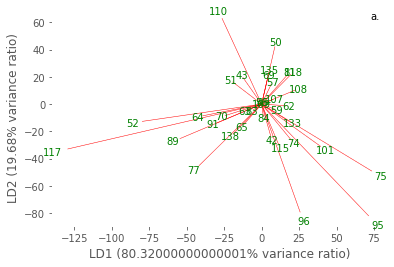

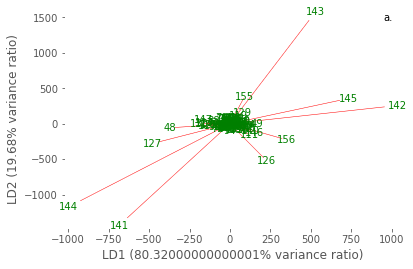

Minimum number of fragments required for 99% accuracy is 27
Fragments required for FMA are: Index([ 42,  43,  44,  50,  51,  56,  57,  58,  59,  62,  63,  70,  75,  77,
        81,  83,  89,  96, 101, 107, 108, 109, 110, 115, 133, 135, 152],
      dtype='object')


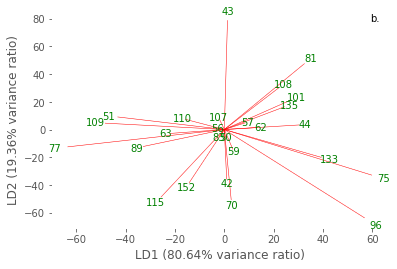

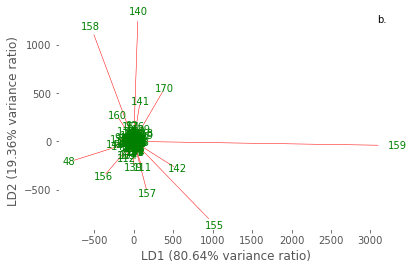

Minimum number of fragments required for 99% accuracy is 42
Fragments required for MMC are: Index([ 42,  43,  44,  50,  51,  52,  53,  54,  55,  56,  58,  59,  62,  63,
        64,  65,  66,  74,  75,  77,  78,  87,  89,  90,  91,  92, 103, 105,
       115, 116, 117, 118, 119, 120, 130, 131, 132, 144, 146, 147, 160, 162],
      dtype='object')


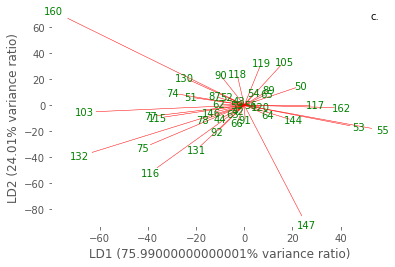

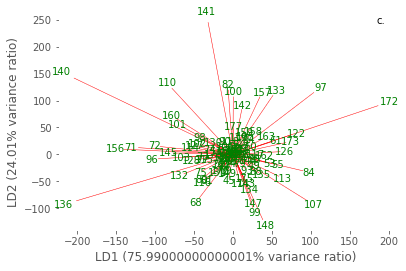

In [12]:
if calc_limitations_2:
    for isomer, df in df_dict.items(): #for each isomer type and its df

        if isomer == 'FA': #remove excess columns
            for column in range(157, 181):
                df = df.drop(column, axis=1)

        if isomer == 'FMA': #remove excess columns
            for column in range(171, 181):
                df = df.drop(column, axis=1)
                
            
        data = df.drop(df.columns[:4], axis=1) #select just data columns
        labels = df["label"] #select just label vector

        roc_dict = {'mahal_accuracy': [], 'num': []} #create empty dictionary for limitations results

        limits_vector = {'m/z':[],'avg abundance':[]} #create empty dictionary
        limits_vector['avg abundance'] = data.mean(axis=0) #calculate average abundance for all isomer IDs of isomer type
        limits_vector['m/z'] = data.columns #fill with m/z values
        df_limits = pd.DataFrame(limits_vector).sort_values('avg abundance', ascending=True) #sort in ascending order of average abundance and convert to dataframe


        #load optimization options
        ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
        std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
        with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
            ms_dict = pickle.load(fo)
        norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
        scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

        std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#         if std_choice == "none": #if that option is none
#             if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                 std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

        norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#         if norm_choice == "none": #if that option is none
#             if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                 norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

        scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#         if scaling_choice == "none": #if that option is none
#             if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                 scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method

        ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
        ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
        ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
        if ms_choice['filter'] == "null": #if that option is null
            if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                if ms_choice['threshold'] == 'null':
                    ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold


        #create empty lists
        minimum = []
        required = []

        for i in tqdm(range(0,len(range(1,500,1))), position=0, leave=False): #for each column
            subtract = range(1,500,1)[i]/10
            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument']) #split the data into training/val
            df_train = df.loc[data_train.index, :] #obtain df info for training
            df_val = df.loc[data_val.index, :]  #obtain df info for val

            data_val = data_val.sub(subtract) #subtract a increasing number to simulat an increasing abundance threshold
            data_val[data_val < 0] = 0 #adjust any negative values to 0

            data_train, data_val = normalize(data_train, data_val, type='9999') #re basepeak normalize to 9999
            data_val2 = data_val.copy() #create a copy (pre-preprocessing)


            #preprocess using optimized method
            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val = std_tune_correction(data=data_val, df=df_val, data_train=data_train, df_train=df_train,
                                           type=std_choice)

            data_train, data_val = ms_removal(data_train, data_val, **ms_choice)

            data_train, data_val = normalize(data_train, data_val, type=norm_choice)
            data_val = data_val.fillna(0)

            data_train, data_val = scaling(data_train, data_val, type=scaling_choice)

            np.random.seed(7) #set random seed
            lda.fit(data_train, label_train) #train LDA model
            data_plot = lda.transform(data_train) #transform training set
            transformed_val = lda.transform(data_val) #transform lowered abundance dataset

            #mahalanobis
            mahal_list_2 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '2'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 2)
            mahal_list_3 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '3'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 3)
            mahal_list_4 = mahalanobis(transformed_val[:,0:2], data_plot[df_train['label'] == '4'][:,0:2]) #using only 1st 2 LD axes, calculate mahalanobis distance of transformed validation set to transformed training set (isomer 4)
            mahal_list = pd.DataFrame( #combine into a dataframe
                {'2': mahal_list_2,
                 '3': mahal_list_3,
                 '4': mahal_list_4, })
            mahal_list['Predicted'] = mahal_list.idxmin(axis=1) #add column with predicted isomer class 
            mahal_list['Actual'] = np.array(label_val) #add column with actual isomer class

            mahal_accuracy = [] #create empty list for accuracy
            
            test = data_val2[list(mahal_list['Predicted'] == mahal_list['Actual'])]
            required.append((test.loc[:,(test!=0).sum(axis=0)>=(test.shape[0]-1)]).columns)#same as above, but no columns to drop


            roc_dict['mahal_accuracy'].append(np.array(mahal_list['Predicted'] == mahal_list['Actual']).mean()) #append to accuracy dict, the accuracy rate

            if roc_dict['mahal_accuracy'][i] < 0.99: #once the accuracy dips below 99%
                minimum.append(i) #append to the minimum list, the i at which it occurs

            roc_dict['num'].append(subtract) #for plot, append i

        final_min = np.array(minimum).min() - 1 #the first i that drops beneath 99% is the line for required fragments, so subtract 1 to get index of last 95% accuracy)
        fragments = required[final_min]
#         fragments = df_limits['m/z'].iloc[final_min:].sort_values()

        print(f'Minimum number of fragments required for 99% accuracy is {len(fragments)}')
        print(f'Fragments required for {isomer} are: {fragments}')
#         print(f'Allowed missing is {allowed_missing}')

        with open(f'{isomer}_fragments.pickle', 'wb') as f: #save final minimum fragments value
            pickle.dump(fragments, f)

#         with open(f'{isomer}_allowing_missing.pickle', 'wb') as f: #save number of allowed missing
#             pickle.dump(allowed_missing, f)

        pd.Series(fragments).to_csv(f'{isomer}_required_fragments.csv')


        #set figure label info
        if isomer == 'FA':
            txt = 'a.'
        if isomer == 'FMA':
            txt = 'b.'
        if isomer == 'MMC':
            txt = 'c.'

        if plot_limitations:
            fig, ax = plt.subplots() #create plot area
            lw = 2 #line width
            plt.plot( #plot number of iterations vs accuracy
                roc_dict['num'],
                roc_dict['mahal_accuracy'],
                color="darkorange",
                lw=lw,
                label="Mahalanobis")
            plt.xlabel("Raised Threshold")
            plt.ylabel("Accuracy Rate")
            plt.text(0.95, 0.95, txt, transform=ax.transAxes)
            plt.savefig(f'{isomer}_limitations2.pdf', dpi=600) #save figure
            plt.show() #show figure

        if minimum_spectra:
            for lab in np.unique(label_train): #for each isomer ID
                fig, ax = plt.subplots() #create plot space
                plt.bar(data[fragments].columns, np.mean(data[fragments][df['label']==lab], axis=0), width=0.6) #plot average abundance for only fragments in minimum required
                plt.xlabel("Required m/z")
                plt.ylabel("Mean Abundance")
#                 plt.ylim(0,2500)
                y = np.array(np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)) #determiner 10 most abundance fragments
                x_loc = (np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(int) #find abundan fragment location
                x_tex = (np.mean(data[fragments][df['label']==lab], axis=0).nlargest(n=10)).index.values.astype(str) #save abundant fragment value
                for i in range(len(y)): #label 10 most abundant (avg) slightly to the right of peak
                     plt.text(float(x_loc[i])*1.01, float(y[i]), str(x_tex[i]))
                plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure label
                plt.savefig(f'{lab}-{isomer}_minimum_spectra2.pdf', dpi=600) #save figure
                plt.show()

        if lda_scalings_plots:
            fig, ax = plt.subplots() #create plot space
            ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate LDA explained variances for axis titles
            ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
            plt.xlabel(f'LD1 ({ld1}% variance ratio)')
            plt.ylabel(f'LD2 ({ld2}% variance ratio)')
            coeff = pd.DataFrame(lda.scalings_).set_index(pd.Series(data_train.columns)) #calculate lda scalings, set index to match m/z columns
            coeff = coeff.loc[coeff.index.intersection(fragments),:] #only plot the scalings for required fragments
            for i in range(coeff.shape[0]):
                plt.arrow(0, 0, coeff.iloc[i,0], coeff.iloc[i,1], color = 'r',alpha = 0.5)
                plt.text(coeff.iloc[i,0]* 1.08, coeff.iloc[i,1] * 1.08, coeff.index[i], color = 'g', ha = 'center', va = 'center')
            plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure label
#             plt.savefig(f'{isomer}_LDA_Scalings_plot2.pdf', dpi = 600) #save figure
            plt.show()
            
            fig, ax = plt.subplots() #create plot space
            ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate LDA explained variances for axis titles
            ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
            plt.xlabel(f'LD1 ({ld1}% variance ratio)')
            plt.ylabel(f'LD2 ({ld2}% variance ratio)')
            coeff = pd.DataFrame(lda.scalings_).set_index(pd.Series(data_train.columns)) #calculate lda scalings, set index to match m/z columns
            # coeff = coeff.loc[coeff.index.intersection(fragments),:] #only plot the scalings for required fragments
            for i in range(coeff.shape[0]):
                plt.arrow(0, 0, coeff.iloc[i,0], coeff.iloc[i,1], color = 'r',alpha = 0.5)
                plt.text(coeff.iloc[i,0]* 1.08, coeff.iloc[i,1] * 1.08, coeff.index[i], color = 'g', ha = 'center', va = 'center')
            plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure label
            plt.savefig(f'{isomer}_LDA_Scalings_plot_all.pdf', dpi = 600) #save figure
            plt.show()



## Apply to NIST Test Set

In [13]:
if NIST_test:
    for isomer, df in df_dict.items():

        df_test = df_dict_test[isomer].reset_index() #import test set, reset index since df is combined df_lib and test set
        
        if isomer == 'FA':
            for column in range(157, 181):
                df = df.drop(column, axis=1)
                df_test = df_test.drop(column, axis=1)

        if isomer == 'FMA':
            for column in range(171, 181):
                df = df.drop(column, axis=1)
                df_test = df_test.drop(column, axis=1)
        
        data_test = df_test.drop(df_test.columns[:5], axis=1) #isolate data for test set
        label_test = df_test['label'] #isolate labels for test set
        data = df.drop(df.columns[:4], axis=1) #isolate data for primary set
        labels = df["label"] #isolate labels for primary set

        data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                        test_size=.3,
                                                                        stratify=df['instrument']) #stratify primary into 70/30 training/val
        df_train = df.loc[data_train.index, :] #grab df info for training set
        df_val = df.loc[data_val.index, :] #grab df info for val set

#         with open(f'{isomer}_final_min.pickle', 'rb') as f: #import final min index
#             final_min = pickle.load(f)

#         with open(f'{isomer}_allowing_missing.pickle', 'rb') as f: #import allowed missing
#             allowed_missing = pickle.load(f)

        with open(f'{isomer}_fragments.pickle', 'rb') as f: #import allowed missing
            required = pickle.load(f)


        limits_vector = {'m/z': [], 'avg abundance': []} #create limits vector
        limits_vector['avg abundance'] = data.mean(axis=0) #fill in with average primary dataset abundance
        limits_vector['m/z'] = data.columns #import m/z values
        df_limits = pd.DataFrame(limits_vector).sort_values('avg abundance', ascending=True) #convert to dataframe and sort according to ascending avg abundance
#         required = df_limits['m/z'].iloc[final_min:] #assign required fragments

#         rows_keep = (data_test[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the test set, allow up to and including the allowed missing
#         rows_keep2 = (data_val[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the validation set, allow up to and including the allowed missing
        rows_keep = (data_test[required] == 0).sum(axis=1) == 0 #set the rows to keep in the test set, allow up to and including the allowed missing
        rows_keep2 = (data_val[required] == 0).sum(axis=1) == 0 #set the rows to keep in the validation set, allow up to and including the allowed missing


        
        data_test_1 = data_test[rows_keep] #test 1 meets the threshold
        data_test_2 = data_test[-rows_keep] #test 2 is below the threshold
        label_test_1 = label_test[data_test_1.index] #test 1 labels that meet the threshold
        label_test_2 = label_test[data_test_2.index] #labels for test 2, below the threshold
        df_test_1 = df_test.loc[data_test_1.index,:] #df info for only above the threshold
        df_test_2 = df_test.loc[data_test_2.index,:] #df info for only below the threshold

        data_val_1 = data_val[rows_keep2] #val 1 meets the threshold
        data_val_2 = data_val[-rows_keep2] #val 2 is below the threshold
        label_val_1 = label_val[data_val_1.index] #labels for val 1, above the threshold
        label_val_2 = label_val[data_val_2.index] #labels for val 2, below the threshold
        df_val_1 = df_val.loc[data_val_1.index,:] #df info for above the threshold
        df_val_2 = df_val.loc[data_val_2.index,:] #df info for below the threshold

        #load optimization options
        ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
        std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
        with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
            ms_dict = pickle.load(fo)
        norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
        scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

        std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#         if std_choice == "none": #if that option is none
#             if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                 std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

        norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#         if norm_choice == "none": #if that option is none
#             if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                 norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

        scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#         if scaling_choice == "none": #if that option is none
#             if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                 scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method


        ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
        ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
        ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
        if ms_choice['filter'] == "null": #if that option is null
            if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                if ms_choice['threshold'] == 'null':
                    ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold


        #Optimize both sets
        data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                         type=std_choice)
        data_val_1, data_test_1 = std_tune_correction(data=data_val_1, df=df_val_1, data_train=data_train, df_train=df_train,
                                       type=std_choice, data_test = data_test_1, df_test = df_test_1)

        data_train, data_val_1, data_test_1 = ms_removal(data_train, data_val_1, **ms_choice, data_test = data_test_1)

        data_train, data_val_1, data_test_1 = normalize(data_train, data_val_1, type=norm_choice, data_test = data_test_1)

        data_train, data_val_1, data_test_1 = scaling(data_train, data_val_1, type=scaling_choice, data_test = data_test_1)


        #restratify (to get original data_train for optimization)

        data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                        test_size=.3,
                                                                        stratify=df['instrument'])
        df_train = df.loc[data_train.index, :]
        df_val = df.loc[data_val.index, :]

        #optimize sets below threshold

        data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                         type=std_choice)
        data_val_2, data_test_2 = std_tune_correction(data=data_val_2, df=df_val_2, data_train=data_train, df_train=df_train,
                                       type=std_choice, data_test = data_test_2, df_test = df_test_2)

        data_train, data_val_2, data_test_2 = ms_removal(data_train, data_val_2, **ms_choice, data_test = data_test_2)

        data_train, data_val_2, data_test_2 = normalize(data_train, data_val_2, type=norm_choice, data_test = data_test_2)

        data_train, data_val_2, data_test_2 = scaling(data_train, data_val_2, type=scaling_choice, data_test = data_test_2)


        np.random.seed(7) #set random seed
        lda.fit(data_train, label_train) #train LDA model

        #transform all datasets
        data_plot = lda.transform(data_train)
        plot_test1 = lda.transform(data_test_1)
        if data_test_2.shape[0]>0:
            plot_test2 = lda.transform(data_test_2)
        plot_val1 = lda.transform(data_val_1)
        if data_val_2.shape[0]>0:
            plot_val2 = lda.transform(data_val_2)


        #mahalanobis
        mahal_list_2 = mahalanobis(plot_test1[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
        mahal_list_3 = mahalanobis(plot_test1[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
        mahal_list_4 = mahalanobis(plot_test1[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
        mahal_list = pd.DataFrame(
        {'2': mahal_list_2,
         '3': mahal_list_3,
         '4': mahal_list_4,})
        mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
        mahal_list['Actual'] = np.array(label_test_1)
        mahal_list.to_csv(f'{isomer}_mahalanobis_opt-NIST_1-2.csv')

        print("Test Set Above Threshold:")
        results = pd.DataFrame({'predictions': mahal_list['Predicted'], 'isomer':mahal_list['Actual']})   # create a dataframe of predictions vs true labels
        ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
        print(ct)
        if (mahal_list['Predicted']!=mahal_list['Actual']).sum()!=0:
            df_test_1.reset_index()[mahal_list['Predicted']!=mahal_list['Actual']].to_csv(f"{isomer}_test_1_incorrect.csv")

        #mahalanobis for test set 2
        if data_test_2.shape[0]>0:
            mahal_list_2 = mahalanobis(plot_test2[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
            mahal_list_3 = mahalanobis(plot_test2[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
            mahal_list_4 = mahalanobis(plot_test2[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
            if plot_test2.shape[0]==1:
                mahal_list = pd.Series(
                {'2': mahal_list_2,
                 '3': mahal_list_3,
                 '4': mahal_list_4})
                mahal_list['Predicted'] = np.array(mahal_list).argmin()+2
                mahal_list['Actual'] = np.array(label_test_2)

            else:
                mahal_list = pd.DataFrame(
                    {'2': mahal_list_2,
                     '3': mahal_list_3,
                     '4': mahal_list_4})
                mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
                mahal_list['Actual'] = np.array(label_test_2)
            mahal_list.to_csv(f'{isomer}_mahalanobis_opt-NIST_2-2.csv')

            print("Test Set Below Threshold:")
            results = pd.DataFrame({'predictions': mahal_list['Predicted'], 'isomer':mahal_list['Actual']})
            ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
            print(ct)
            if (mahal_list['Predicted']!=mahal_list['Actual']).sum()!=0:
                df_test_2.reset_index()[mahal_list['Predicted']!=mahal_list['Actual']].to_csv(f"{isomer}_test_2_incorrect.csv")


        #mahalanobis Val set 1
        mahal_list_2 = mahalanobis(plot_val1[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
        mahal_list_3 = mahalanobis(plot_val1[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
        mahal_list_4 = mahalanobis(plot_val1[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
        mahal_list = pd.DataFrame(
        {'2': mahal_list_2,
         '3': mahal_list_3,
         '4': mahal_list_4,})
        mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
        mahal_list['Actual'] = np.array(label_val_1)
        print("Validation Set Above Threshold")
        results = pd.DataFrame({'predictions': mahal_list['Predicted'], 'isomer': mahal_list['Actual']})
        ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
        print(ct)
        if (mahal_list['Predicted']!=mahal_list['Actual']).sum()!=0:
            df_val_1.reset_index()[mahal_list['Predicted']!=mahal_list['Actual']].to_csv(f"{isomer}_val_1_incorrect.csv")

        mahal_list.to_csv(f'{isomer}_mahalanobis_opt-Val_1-2.csv')


        #mahalanobis val set 2
        if data_val_2.shape[0]>0:
            mahal_list_2 = mahalanobis(plot_val2[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
            mahal_list_3 = mahalanobis(plot_val2[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
            mahal_list_4 = mahalanobis(plot_val2[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
            if plot_val2.shape[0]==1:
                mahal_list = pd.Series(
                {'2': mahal_list_2,
                 '3': mahal_list_3,
                 '4': mahal_list_4})
                mahal_list['Predicted'] = np.array(mahal_list).argmin()+2
                mahal_list['Actual'] = np.array(label_val_2)
            else:
                mahal_list = pd.DataFrame(
                    {'2': mahal_list_2,
                     '3': mahal_list_3,
                     '4': mahal_list_4})
                mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
                mahal_list['Actual'] = np.array(label_val_2)

            print("Validation Set Below Threshold:")
            results = pd.DataFrame({'predictions': mahal_list['Predicted'], 'isomer': mahal_list['Actual']})
            ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
            print(ct)
            if (mahal_list['Predicted']!=mahal_list['Actual']).sum()!=0:
                df_val_2.reset_index()[mahal_list['Predicted']!=mahal_list['Actual']].to_csv(f"{isomer}_val_2_incorrect.csv")

            mahal_list.to_csv(f'{isomer}_mahalanobis_opt-Val_2-2.csv')

        #plot
        fig, ax = plt.subplots() #set plot area
        fig.subplots_adjust(bottom=0.32) #move plot up to leave room for legend
        #set figure text
        if isomer == 'FA':
            txt = 'a.'
        if isomer == 'FMA':
            txt = 'b.'
        if isomer == 'MMC':
            txt = 'c.'
        colors = ['r', 'g', 'b']
        ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100 #calculate lda variances
        ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
        target_names = [f'2-{isomer}', f'3-{isomer}', f'4-{isomer}']
        for color, z, target_name in zip(colors, ["2", "3", "4"], target_names):
            plt.scatter(data_plot[label_train == z, 0], data_plot[label_train == z, 1], alpha=.8, color=color,
                        label=target_name) #plot training set
        #plots validation/test sets
        plt.scatter(0,0, color="white", label = " ")
        plt.scatter(plot_val1[:, 0], plot_val1[:, 1], color="y", label="Validation - Above Threshold")
        if data_val_2.shape[0]>0:
            plt.scatter(plot_val2[:, 0], plot_val2[:, 1], color="y", label="Validation - Below Threshold", marker="^")
        plt.scatter(plot_test1[:, 0], plot_test1[:, 1], color="black", label="Test - Above Threshold")
        if data_test_2.shape[0]>0:
            plt.scatter(plot_test2[:, 0], plot_test2[:, 1], color="black", label="Test - Below Threshold", marker="^")
        plt.legend(bbox_to_anchor=(0.55, -0.55), loc='lower center', ncol=2, shadow=False, scatterpoints=1) #plot legend
        plt.xlabel(f'LD1 ({ld1}% variance ratio)')
        plt.ylabel(f'LD2 ({ld2}% variance ratio)')
        plt.text(0.95, 0.95, txt, transform=ax.transAxes) #add figure text
#         plt.savefig(f'{isomer}_optimized_NIST_val2.pdf', dpi=600) #save figure
        plt.show() #show figure
    

## Convert Coelution samples

In [14]:
if coelution_test:
    directory = "/Users/jenniferbonetti/PycharmProjects/pythonProject/Mix" #set directory
    files = glob.glob(directory+"/*") #set files
    data_dict = {"isomer": [], "label": [], "tune": [], 'type':[]} #create empty dictionary
    data_dict.update({key:[] for key in range(lower_bound, upper_bound)}) #
    for file in tqdm(files):
        filename = file.split("/")[-1]
        isomers = ["FA", "FMA", "MMC"]
        isomer = "NA"
        label = filename[5]
        for tmp_isomer in isomers:
            if tmp_isomer in filename:
                isomer = tmp_isomer

        tune = 'A' #all coelution samples were autotunes

        #set info regarding peak and background
        if "front" in filename or "back" in filename:
            if "inside" in filename:
                type_id = 'inside-side-'
            else:
                if "outside" in filename:
                    type_id = 'outside-side'
                else:
                    type_id = '-side'

        else:
            if "inside" in filename:
                if re.search("inside[0-9]b", filename):
                    type_id = 'inside-peak-mid'
                else:
                    if re.search("inside[0-9]a", filename):
                        type_id = 'inside-peak-front'
                    else:
                        type_id = 'inside-peak'
            else:
                if "outside" in filename:
                    type_id = 'outside-peak'
                else:
                    type_id = '-peak'

        data_dict["isomer"].append(isomer)
        data_dict["label"].append(label)
        data_dict["type"].append(type_id)
        data_dict["tune"].append(tune)

        if "_manual" in filename:
            tmp_df = read_file(file, manual=True)
        else:
            tmp_df = read_file(file)
        for i, row in tmp_df.iterrows():
            data_dict[i].append(row["abund."])

    main_df = pd.DataFrame(data_dict)
    main_df.to_pickle("mix_data.pkl")

## Test FA Coelution samples

In [15]:
if coelution_test:
    df = pd.read_pickle("data.pkl")
    df_test_set = pd.read_pickle("mix_data.pkl") #change test set to coelution data

    isomers = df.groupby("isomer").count().index.values
    for isomer in isomers:
        df_dict[isomer] = df[df["isomer"] == isomer]
        df_dict_test[isomer] = df_test_set[df_test_set['isomer'] == isomer] #change test set data 

    for isomer, df in df_dict.items():

        df_test = df_dict_test[isomer].reset_index()

        #restrict to necessary m/z
        if isomer == 'FA':
            for column in range(157, 181):
                df = df.drop(column, axis=1)
                df_test = df_test.drop(column, axis=1)
                
            data_test = df_test.drop(df_test.columns[:5], axis=1) #isolate data for test set
            label_test = df_test['label'] #isolate labels for test set
            data = df.drop(df.columns[:4], axis=1) #isolate data for primary set
            labels = df["label"] #isolate labels for primary set

            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument']) #stratify primary into 70/30 training/val
            df_train = df.loc[data_train.index, :] #grab df info for training set
            df_val = df.loc[data_val.index, :] #grab df info for val set

#             with open(f'{isomer}_final_min.pickle', 'rb') as f: #import final min index
#                 final_min = pickle.load(f)

#             with open(f'{isomer}_allowing_missing.pickle', 'rb') as f: #import allowed missing
#                 allowed_missing = pickle.load(f)

            with open(f'{isomer}_fragments.pickle', 'rb') as f: #import allowed missing
                required = pickle.load(f)

            limits_vector = {'m/z': [], 'avg abundance': []} #create limits vector
            limits_vector['avg abundance'] = data.mean(axis=0) #fill in with average primary dataset abundance
            limits_vector['m/z'] = data.columns #import m/z values
            df_limits = pd.DataFrame(limits_vector).sort_values('avg abundance', ascending=True) #convert to dataframe and sort according to ascending avg abundance
#             required = df_limits['m/z'].iloc[final_min:] #assign required fragments

#             rows_keep = (data_test[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the test set, allow up to and including the allowed missing
#             rows_keep2 = (data_val[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the validation set, allow up to and including the allowed missing
            rows_keep = (data_test[required] == 0).sum(axis=1) == 0 #set the rows to keep in the test set, allow up to and including the allowed missing
            rows_keep2 = (data_val[required] == 0).sum(axis=1) == 0 #set the rows to keep in the validation set, allow up to and including the allowed missing

            data_test_1 = data_test[rows_keep] #test 1 meets the threshold
            data_test_2 = data_test[-rows_keep] #test 2 is below the threshold
            label_test_1 = label_test[data_test_1.index] #test 1 labels that meet the threshold
            label_test_2 = label_test[data_test_2.index] #labels for test 2, below the threshold
            df_test_1 = df_test.loc[data_test_1.index,:] #df info for only above the threshold
            df_test_2 = df_test.loc[data_test_2.index,:] #df info for only below the threshold

            data_val_1 = data_val[rows_keep2] #val 1 meets the threshold
            data_val_2 = data_val[-rows_keep2] #val 2 is below the threshold
            label_val_1 = label_val[data_val_1.index] #labels for val 1, above the threshold
            label_val_2 = label_val[data_val_2.index] #labels for val 2, below the threshold
            df_val_1 = df_val.loc[data_val_1.index,:] #df info for above the threshold
            df_val_2 = df_val.loc[data_val_2.index,:] #df info for below the threshold

            #load optimization options
            ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
            std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
            with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
                ms_dict = pickle.load(fo)
            norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
            scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

            std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#             if std_choice == "none": #if that option is none
#                 if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                     std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

            norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#             if norm_choice == "none": #if that option is none
#                 if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                     norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

            scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#             if scaling_choice == "none": #if that option is none
#                 if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                     scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method

            ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
            ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
            ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
            ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
            if ms_choice['filter'] == "null": #if that option is null
                if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                    ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                    if ms_choice['threshold'] == 'null':
                        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold
            
            #Optimize both sets
            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val_1, data_test_1 = std_tune_correction(data=data_val_1, df=df_val_1, data_train=data_train, df_train=df_train,
                                           type=std_choice, data_test = data_test_1, df_test = df_test_1)

            data_train, data_val_1, data_test_1 = ms_removal(data_train, data_val_1, **ms_choice, data_test = data_test_1)

            data_train, data_val_1, data_test_1 = normalize(data_train, data_val_1, type=norm_choice, data_test = data_test_1)

#             data_train[data_train<0]=0
#             data_val_1[data_val_1<0]=0
#             data_test_1[data_test_1<0]=0
            data_train, data_val_1, data_test_1 = scaling(data_train, data_val_1, type=scaling_choice, data_test = data_test_1)


            #restratify (to get original data_train for optimization)

            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument'])
            df_train = df.loc[data_train.index, :]
            df_val = df.loc[data_val.index, :]

            #optimize sets below threshold

            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val_2, data_test_2 = std_tune_correction(data=data_val_2, df=df_val_2, data_train=data_train, df_train=df_train,
                                           type=std_choice, data_test = data_test_2, df_test = df_test_2)

            data_train, data_val_2, data_test_2 = ms_removal(data_train, data_val_2, **ms_choice, data_test = data_test_2)

            data_train, data_val_2, data_test_2 = normalize(data_train, data_val_2, type=norm_choice, data_test = data_test_2)

#             data_train[data_train<0]=0
#             data_val_2[data_val_2<0]=0
#             data_test_2[data_test_2<0]=0
            data_train, data_val_2, data_test_2 = scaling(data_train, data_val_2, type=scaling_choice, data_test = data_test_2)


            np.random.seed(7)
            lda.fit(data_train, label_train) #train LDA model
            data_plot = lda.transform(data_train)
            plot_test1 = lda.transform(data_test_1[df_test_1['type'].str.contains('peak')])
#             plot_test2 = lda.transform(data_test_2[df_test_2['type'].str.contains('peak')])
            plot_test1a = lda.transform(data_test_1[df_test_1['type'].str.contains('side')])
#             plot_test2a = lda.transform(data_test_2[df_test_2['type'].str.contains('side')])
            #no FA samples under threshold

            #mahalanobis
            mahal_list_2 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
            mahal_list_3 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
            mahal_list_4 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
            mahal_list = pd.DataFrame(
            {'2': mahal_list_2,
             '3': mahal_list_3,
             '4': mahal_list_4})
            mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
            mahal_list['Actual'] = np.array(label_test_1)
            mahal_accuracy = (mahal_list['Predicted'] == mahal_list['Actual']).mean()

            print("Test Set Above Threshold:")
            results = pd.DataFrame({'predictions': mahal_list['Predicted'],
                                    'isomer': mahal_list['Actual']})  # create a dataframe of predictions vs true labels
            ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
            print(ct)

            fig, ax = plt.subplots()
            fig.subplots_adjust(bottom=0.3)
            txt = 'a.'
            colors = ['r', 'g', 'b']
            ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100
            ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
            target_names = [f'2-{isomer}', f'3-{isomer}', f'4-{isomer}']
            for color, z, target_name in zip(colors, ["2", "3", "4"], target_names):
                plt.scatter(data_plot[label_train == z, 0], data_plot[label_train == z, 1], alpha=.8, color=color,
                            label=target_name)
            plt.scatter(plot_test1[:, 0], plot_test1[:, 1], color="black", label="Test - Above Threshold (peak)")
#             plt.scatter(plot_test2[:, 0], plot_test2[:, 1], color="black", label="Test - Below Threshold (Peak)", marker="^")
            plt.scatter(plot_test1a[:, 0], plot_test1a[:, 1], color="purple", label="Test - Above Threshold (Side)")
#             plt.scatter(plot_test2a[:, 0], plot_test2a[:, 1], color="purple", label="Test - Below Threshold (Side)",
#                         marker="^")

            plt.legend(bbox_to_anchor=(0.5, -0.55), loc='lower center', ncol=2, shadow=False, scatterpoints=1)

            plt.xlabel(f'LD1 ({ld1}% variance ratio)')
            plt.ylabel(f'LD2 ({ld2}% variance ratio)')
            plt.text(0.97, 0.97, txt, transform=ax.transAxes)
            plt.savefig(f'{isomer}_coelute_DFS2.pdf', dpi=600) #save figure
            plt.show() #show figure


## Test FMA Coelution samples

In [16]:
if coelution_test:
    df = pd.read_pickle("data.pkl")
    df_test_set = pd.read_pickle("mix_data.pkl") #change test set to coelution data

    isomers = df.groupby("isomer").count().index.values
    for isomer in isomers:
        df_dict[isomer] = df[df["isomer"] == isomer]
        df_dict_test[isomer] = df_test_set[df_test_set['isomer'] == isomer] #change test set data 

    for isomer, df in df_dict.items():

        df_test = df_dict_test[isomer].reset_index()

        #restrict to necessary m/z
        if isomer == 'FMA':
            for column in range(171, 181):
                df = df.drop(column, axis=1)
                df_test = df_test.drop(column, axis=1)
                
            data_test = df_test.drop(df_test.columns[:5], axis=1) #isolate data for test set
            label_test = df_test['label'] #isolate labels for test set
            data = df.drop(df.columns[:4], axis=1) #isolate data for primary set
            labels = df["label"] #isolate labels for primary set

            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument']) #stratify primary into 70/30 training/val
            df_train = df.loc[data_train.index, :] #grab df info for training set
            df_val = df.loc[data_val.index, :] #grab df info for val set

#             with open(f'{isomer}_final_min.pickle', 'rb') as f: #import final min index
#                 final_min = pickle.load(f)

#             with open(f'{isomer}_allowing_missing.pickle', 'rb') as f: #import allowed missing
#                 allowed_missing = pickle.load(f)

            with open(f'{isomer}_fragments.pickle', 'rb') as f: #import allowed missing
                required = pickle.load(f)

            limits_vector = {'m/z': [], 'avg abundance': []} #create limits vector
            limits_vector['avg abundance'] = data.mean(axis=0) #fill in with average primary dataset abundance
            limits_vector['m/z'] = data.columns #import m/z values
            df_limits = pd.DataFrame(limits_vector).sort_values('avg abundance', ascending=True) #convert to dataframe and sort according to ascending avg abundance
#             required = df_limits['m/z'].iloc[final_min:] #assign required fragments

#             rows_keep = (data_test[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the test set, allow up to and including the allowed missing
#             rows_keep2 = (data_val[required] == 0).sum(axis=1) <= allowed_missing #set the rows to keep in the validation set, allow up to and including the allowed missing
            rows_keep = (data_test[required] == 0).sum(axis=1) == 0 #set the rows to keep in the test set, allow up to and including the allowed missing
            rows_keep2 = (data_val[required] == 0).sum(axis=1) == 0 #set the rows to keep in the validation set, allow up to and including the allowed missing


            data_test_1 = data_test[rows_keep] #test 1 meets the threshold
            data_test_2 = data_test[-rows_keep] #test 2 is below the threshold
            label_test_1 = label_test[data_test_1.index] #test 1 labels that meet the threshold
            label_test_2 = label_test[data_test_2.index] #labels for test 2, below the threshold
            df_test_1 = df_test.loc[data_test_1.index,:] #df info for only above the threshold
            df_test_2 = df_test.loc[data_test_2.index,:] #df info for only below the threshold

            data_val_1 = data_val[rows_keep2] #val 1 meets the threshold
            data_val_2 = data_val[-rows_keep2] #val 2 is below the threshold
            label_val_1 = label_val[data_val_1.index] #labels for val 1, above the threshold
            label_val_2 = label_val[data_val_2.index] #labels for val 2, below the threshold
            df_val_1 = df_val.loc[data_val_1.index,:] #df info for above the threshold
            df_val_2 = df_val.loc[data_val_2.index,:] #df info for below the threshold

            #load optimization options
            ms_choice = {'low_percentage': [], 'high_percentage': [], 'filter': [], 'threshold': []} #create empty dictionary
            std_list = pd.read_pickle(f"{isomer}_final_std.pkl") #read in std list
            with open(f"{isomer}_final_ms.pickle", "rb") as fo: #read in ms dictionary
                ms_dict = pickle.load(fo)
            norm_list = pd.read_pickle(f"{isomer}_final_normal.pkl") #read in normalization list
            scaling_list = pd.read_pickle(f"{isomer}_final_scaling.pkl") #read in scaling list

            std_choice = std_list.value_counts(sort=True).index[0] #set std choice to most common option
#             if std_choice == "none": #if that option is none
#                 if std_list.value_counts(sort=True).loc['none'] < len(std_list)/2: #check if more than half use any std method
#                     std_choice = std_list.value_counts(sort=True).index[1] #if so, set std choice to highest option with a method applied

            norm_choice = norm_list.value_counts(sort=True).index[0] #set normalization choice to most common option
#             if norm_choice == "none": #if that option is none
#                 if norm_list.value_counts(sort=True).loc['none'] < len(norm_list)/2: #check if more than half use any normalization method
#                     norm_choice = norm_list.value_counts(sort=True).index[1] #if so, set norm choice to highest option with a method applied

            scaling_choice = scaling_list.value_counts(sort=True).index[0] #set scaling choice to most common option
#             if scaling_choice == "none": #if that option is none
#                 if scaling_list.value_counts(sort=True).loc['none'] < len(scaling_list)/2: #check if more than half use any scaling method
#                     scaling_choice = scaling_list.value_counts(sort=True).index[1] #if so, apply the most common method

            ms_choice['low_percentage'] = pd.DataFrame(ms_dict['low_percentage']).value_counts(sort=True).index[0][0] #set the low percentage to the most common
            ms_choice['high_percentage'] = pd.DataFrame(ms_dict['high_percentage']).value_counts(sort=True).index[0][0] #set the high percentage to the most common
            ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[0][0] #set the filter to the most common option
            ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[0][0] #apply the most common threshold
            if ms_choice['filter'] == "null": #if that option is null
                if pd.DataFrame(ms_dict['filter']).value_counts(sort=True).loc['null'].iloc[0] < len(ms_dict['filter'])/2: #check if more than half use a filter option
                    ms_choice['filter'] = pd.DataFrame(ms_dict['filter']).value_counts(sort=True).index[1][0]        #if so, apply the most common filter
                    if ms_choice['threshold'] == 'null':
                        ms_choice['threshold'] = pd.DataFrame(ms_dict['threshold']).value_counts(sort=True).index[1][0] #apply the most common threshold


            #Optimize both sets
            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val_1, data_test_1 = std_tune_correction(data=data_val_1, df=df_val_1, data_train=data_train, df_train=df_train,
                                           type=std_choice, data_test = data_test_1, df_test = df_test_1)

            data_train, data_val_1, data_test_1 = ms_removal(data_train, data_val_1, **ms_choice, data_test = data_test_1)

            data_train, data_val_1, data_test_1 = normalize(data_train, data_val_1, type=norm_choice, data_test = data_test_1)

#             data_train[data_train<0]=0
#             data_val_1[data_val_1<0]=0
#             data_test_1[data_test_1<0]=0
            data_train, data_val_1, data_test_1 = scaling(data_train, data_val_1, type=scaling_choice, data_test = data_test_1)


            #restratify (to get original data_train for optimization)

            data_train, data_val, label_train, label_val = train_test_split(data, labels, random_state=7,
                                                                            test_size=.3,
                                                                            stratify=df['instrument'])
            df_train = df.loc[data_train.index, :]
            df_val = df.loc[data_val.index, :]

            #optimize sets below threshold

            data_train = std_tune_correction(data=data_train, df=df_train, data_train=data_train, df_train=df_train,
                                             type=std_choice)
            data_val_2, data_test_2 = std_tune_correction(data=data_val_2, df=df_val_2, data_train=data_train, df_train=df_train,
                                           type=std_choice, data_test = data_test_2, df_test = df_test_2)

            data_train, data_val_2, data_test_2 = ms_removal(data_train, data_val_2, **ms_choice, data_test = data_test_2)

            data_train, data_val_2, data_test_2 = normalize(data_train, data_val_2, type=norm_choice, data_test = data_test_2)

#             data_train[data_train<0]=0
#             data_val_2[data_val_2<0]=0
#             data_test_2[data_test_2<0]=0
            data_train, data_val_2, data_test_2 = scaling(data_train, data_val_2, type=scaling_choice, data_test = data_test_2)


            np.random.seed(7)
            lda.fit(data_train, label_train) #train LDA model
            data_plot = lda.transform(data_train)
            plot_test1 = lda.transform(data_test_1[df_test_1['type'].str.contains('outside')])
#             plot_test2 = lda.transform(data_test_2[df_test_2['type'].str.contains('outside')])
            plot_test1b = lda.transform(data_test_1[df_test_1['type'].str.contains('-side')])
#             plot_test2b = lda.transform(data_test_2[df_test_2['type'].str.contains('-side')])
            plot_test3 = lda.transform(data_test_1[df_test_1['type']=='inside-peak']) #2-FMA doesn't have mid/front designation, all peak - inside -a
#             plot_test4 = lda.transform(data_test_2[df_test_2['type']=='inside-peak']) #2-FMA doesn't have mid/front designation, all peak - inside -a
#             plot_test5 = lda.transform(data_test_1[df_test_1['type'].str.contains('-mid')]) #mid and front are only for peaks, not side
            plot_test6 = lda.transform(data_test_2[df_test_2['type'].str.contains('-mid')])
            plot_test7 = lda.transform(data_test_1[df_test_1['type'].str.contains('-front')])
#             plot_test8 = lda.transform(data_test_2[df_test_2['type'].str.contains('-front')])



            #mahalanobis
            mahal_list_2 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
            mahal_list_3 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
            mahal_list_4 = mahalanobis(lda.transform(data_test_1)[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
            mahal_list = pd.DataFrame(
            {'2': mahal_list_2,
             '3': mahal_list_3,
             '4': mahal_list_4})
            mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
            mahal_list['Actual'] = np.array(label_test_1)
            mahal_accuracy = (mahal_list['Predicted'] == mahal_list['Actual']).mean()

            print("Test Set Above Threshold:")
            results = pd.DataFrame({'predictions': mahal_list['Predicted'],
                                    'isomer': mahal_list['Actual']})  # create a dataframe of predictions vs true labels
            ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
            print(ct)
            
            #mahalanobis under threshold
            mahal_list_2 = mahalanobis(lda.transform(data_test_2)[:,0:2], data_plot[df_train['label'] == '2'][:,0:2])
            mahal_list_3 = mahalanobis(lda.transform(data_test_2)[:,0:2], data_plot[df_train['label'] == '3'][:,0:2])
            mahal_list_4 = mahalanobis(lda.transform(data_test_2)[:,0:2], data_plot[df_train['label'] == '4'][:,0:2])
            mahal_list = pd.DataFrame(
            {'2': mahal_list_2,
             '3': mahal_list_3,
             '4': mahal_list_4})
            mahal_list['Predicted'] = mahal_list.idxmin(axis=1)
            mahal_list['Actual'] = np.array(label_test_2)
            mahal_accuracy = (mahal_list['Predicted'] == mahal_list['Actual']).mean()

            print("Test Set Below Threshold:")
            results = pd.DataFrame({'predictions': mahal_list['Predicted'],
                                    'isomer': mahal_list['Actual']})  # create a dataframe of predictions vs true labels
            ct = pd.crosstab(results['predictions'], results['isomer'])  # create a cross-tab of results/true labels
            print(ct)

            fig, ax = plt.subplots() #set plot area
            fig.subplots_adjust(bottom=0.35) #adjust for legend
            txt = 'b.' #figure text
            colors = ['r', 'g', 'b']
            ld1 = round_sig(lda.explained_variance_ratio_[0], 4) * 100
            ld2 = round_sig(lda.explained_variance_ratio_[1], 4) * 100
            target_names = [f'2-{isomer}', f'3-{isomer}', f'4-{isomer}']
            for color, z, target_name in zip(colors, ["2", "3", "4"], target_names):
                plt.scatter(data_plot[label_train == z, 0], data_plot[label_train == z, 1], alpha=.8, color=color,
                            label=target_name)
            plt.scatter(0,0,color = "white", label = " ")
            plt.scatter(plot_test1[:, 0], plot_test1[:, 1], color="black", label="Test - Above Threshold (Peak-outside)")
#             plt.scatter(plot_test2[:, 0], plot_test2[:, 1], color="black", label="Test - Below Threshold (Peak-outside)", marker="^")
            plt.scatter(plot_test1b[:, 0], plot_test1b[:, 1], color="brown",
                        label="Test - Above Threshold (Side-inside-a)")
#             plt.scatter(plot_test2b[:, 0], plot_test2b[:, 1], color="brown",
#                         label="Test - Below Threshold (Side-inside-a)",
#                         marker="^")
            plt.scatter(np.concatenate((plot_test3[:, 0],plot_test7[:, 0])), np.concatenate((plot_test3[:, 1],plot_test7[:, 1])), color="y", label="Test - Above Threshold (Peak-inside-a)")
#             plt.scatter(np.concatenate((plot_test4[:, 0],plot_test6[:, 0])), np.concatenate((plot_test4[:, 1],plot_test6[:, 1])), color="y", label="Test - Below Threshold (Peak-inside-a)", marker="^")
            plt.scatter(plot_test6[:, 0], plot_test6[:, 1], color="purple", label="Test - Below Threshold (Peak-inside-b)", marker = "^")


#             plt.scatter(plot_test5[:, 0], plot_test5[:, 1], color="purple", label="Test - Above Threshold (Peak-inside-b)")

#             plt.scatter(plot_test8[:, 0], plot_test8[:, 1], color="y", label="Test - Below Threshold (Peak-inside-a)", marker="^")


            plt.legend(bbox_to_anchor=(0.45, -0.65), loc='lower center', ncol=2, shadow=False, scatterpoints=1)

            plt.xlabel(f'LD1 ({ld1}% variance ratio)')
            plt.ylabel(f'LD2 ({ld2}% variance ratio)')
            plt.text(0.97, 0.97, txt, transform=ax.transAxes)
            plt.savefig(f'{isomer}_DFS_coelute2.pdf', dpi=600)
            plt.show()
